In [1]:
import pandas as pd; pd.set_option('max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
from matplotlib import cm
import seaborn as sns; sns.set(font='Malgun Gothic'); 
import warnings; warnings.filterwarnings(action='ignore')

import yfinance as yf # 야후 파이낸스
import bt             # 백테스트 라이브러리
import pyfolio as pf  # 백테스트 시각화 라이브러리
import talib          # 보조지표 라이브러리

# 변수 정의

In [2]:
# 데이터 수집 기간 및 베이스라인 : 
# , 백테스팅을 위해 여분
start_date_pad = '2003-07-29'
end_date_pad   = '2021-10-29'

# 학습 기간
start_date_train = '2003-09-29'
end_date_train   = '2011-09-28'

# 예측 기간
start_date_pred = '2011-09-29'
end_date_pred   = '2021-09-28'

# 백테스트 기간 : HV_resid 활용을 위해 20일 여분
start_date_bt = '2011-09-29'
end_date_bt   = '2021-08-28'

# 주가 데이터 수집

In [3]:
# 지수
indice_tickers = ['^KS11', '^GSPC', '^IXIC',  '^N225',  '^HSI',     '^FCHI', '^GDAXI']
indice_names   = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax']

# 지수 추종 ETF   : 코스피,   S&P500,  나스닥,   닛케이,     홍콩,       프랑스,   독일,   미 국채
etf_tickers    = ['EWY',   'SPY',   'QQQ',    'EWJ',    'EWH',      'EWQ',   'EWG', 'AGG']
etf_names      = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax', 'agg']

# 지수 OHLCV
indice = yf.download(indice_tickers, start=start_date_pad, end=end_date_pad)
# 지수 추종 OHLCV
etf    = yf.download(etf_tickers, start=start_date_pad, end=end_date_pad)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  8 of 8 completed


In [4]:
etf['Adj Close']

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-07-28,NaN,8.589716,4.700956,24.707079,10.765283,17.662933,27.658081,69.914581
2003-07-29,NaN,8.562790,4.724342,24.390322,10.625310,17.903790,27.449930,69.592514
2003-07-30,NaN,8.475276,4.712650,23.883507,10.695297,17.767307,27.250454,69.424484
2003-07-31,NaN,8.549324,4.765273,24.073559,10.708021,17.422075,27.580029,69.585526
2003-08-01,NaN,8.414690,4.741885,23.788485,10.517147,17.767307,27.285141,68.969376
...,...,...,...,...,...,...,...,...
2021-10-22,113.720169,33.779999,24.680000,68.419998,38.970001,80.360001,374.100006,453.119995
2021-10-25,113.829842,33.810001,24.760000,68.449997,38.639999,81.440002,377.929993,455.549988
2021-10-26,114.039215,33.990002,24.700001,68.459999,38.849998,82.029999,379.119995,455.959991


# 지수와 지수 추종 ETF의 상관관계

In [5]:
pd.concat([indice['Adj Close'], etf['Adj Close']], axis=1).corr().iloc[:7, -7:]

# 코스피 : 0.977490
# sp500 : 0.998325
# 나스닥 : 0.998903
# 닛케이 : 0.976603
# 항셍   : 0.906356
# 프랑스 : 0.883865
# 독일   : 0.952550

,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
^FCHI,0.761684,0.652673,0.891918,0.883865,0.665407,0.657152,0.710768
^GDAXI,0.952550,0.972969,0.902571,0.908758,0.889398,0.886084,0.938418
^GSPC,0.867086,0.918053,0.932788,0.900267,0.838659,0.981866,0.998325
^HSI,0.915804,0.906209,0.755362,0.851426,0.890064,0.661430,0.724548
^IXIC,0.821541,0.884684,0.900776,0.861896,0.822208,0.998903,0.991702
^KS11,0.922005,0.913987,0.783275,0.849110,0.977507,0.796164,0.821396
^N225,0.841787,0.831794,0.976605,0.906230,0.760641,0.875038,0.913019


# 글라이드 패스 함수

In [6]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(['2003-09-29', '2004-09-29', '2005-09-29', '2006-09-29','2007-09-28', '2008-09-29', '2009-09-29', '2010-09-29','2011-09-29', '2012-09-28', '2013-09-30', '2014-09-29','2015-09-29', '2016-09-29', '2017-09-29', '2018-09-28','2019-09-30', '2020-09-29', '2021-08-28'])
    df.drop('RA', axis=1, inplace=True)
    
    return df

# baseline 변동성

In [7]:
# 위험자산내 비중 [독일,   홍콩,  일본,   프랑스, 한국,   S&P,   나스닥]
risk_weight   = [.0250, .0250, .0375, .0375, .2500, .2000, .4250]

# baseline 변동성의 글라이드 패스 : 안전자산 없이 위험자산으로만 구성(가장 큰 변동성 확인 가능)
gw_baseline = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
gp_baseline = makeGlidePath(etf, gw_baseline, risk_weight, start_year=int(start_date_pad[:4]))
gp_baseline

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2003-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2004-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2005-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2006-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2007-09-28,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2008-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2009-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2010-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2011-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2012-09-28,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425


In [8]:
# 백테스팅의 데이터
baseline_data = etf['Adj Close'].loc[start_date_pad:]

# 백테스팅 전략
baseline_strategy = bt.Strategy(
    'baseline', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_baseline), 
        bt.algos.Rebalance(), 
    ]
)
# 백테스트
baseline_backtest = bt.Backtest(strategy=baseline_strategy, data=baseline_data)
baseline_result   = bt.run(baseline_backtest)

In [9]:
baseline_result.prices

,baseline
2003-07-28,100.000000
2003-07-29,100.000000
2003-07-30,100.000000
2003-07-31,100.000000
2003-08-01,100.000000
...,...
2021-10-22,672.347303
2021-10-25,677.330129
2021-10-26,679.394631
2021-10-27,675.912691


In [10]:
baseline_result.stats # 백테스트 요약 결과

,baseline
start,2003-07-28 00:00:00
end,2021-10-28 00:00:00
rf,0.0
total_return,5.813646
cagr,0.110853
max_drawdown,-0.58885
calmar,0.188253
mtd,0.048472
three_month,0.004992
six_month,0.033975


## 백테스트 결과 시각화

In [11]:
%matplotlib inline
# baseline_result.prices.to_drawdown_series().plot() # MDD(최대낙폭)

In [12]:
baseline_returns = baseline_result.prices.to_returns().iloc[1:, 0]
# baseline_returns.plot() # 일별 수익률

In [13]:
# pyfolio 종합 plot
# pf.create_full_tear_sheet(baseline_returns)

In [14]:
# pf.plot_drawdown_periods(returns=baseline_returns, top=10)

In [15]:
# pf.plot_returns(baseline_returns)

In [16]:
# pf.plot_annual_returns(baseline_returns)

In [17]:
# pf.plot_drawdown_underwater(baseline_returns)

In [18]:
# pf.plot_monthly_returns_dist(baseline_returns)

In [19]:
# pf.plot_monthly_returns_heatmap(baseline_returns)

In [20]:
# pf.plot_monthly_returns_timeseries(baseline_returns)

In [21]:
# pf.plot_return_quantiles(baseline_returns)

In [22]:
# pf.plot_rolling_returns(baseline_returns)

In [23]:
# pf.plot_rolling_sharpe(baseline_returns)

In [24]:
# pf.plot_rolling_volatility(baseline_returns)

## baseline 변동성 데이터

In [25]:
baseline_hv = baseline_result.prices
baseline_hv['HV']          = baseline_hv.iloc[:, 0].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
baseline_hv['HV_pred_5']   = baseline_hv.iloc[:, 1].shift(-5)
baseline_hv['HV_pred_10']  = baseline_hv.iloc[:, 1].shift(-10)
baseline_hv['HV_pred_15']  = baseline_hv.iloc[:, 1].shift(-15)
baseline_hv['HV_pred_20']  = baseline_hv.iloc[:, 1].shift(-20)
baseline_hv['HV_resid_5']  = baseline_hv.iloc[:, 1].diff(-5)
baseline_hv['HV_resid_10'] = baseline_hv.iloc[:, 1].diff(-10)
baseline_hv['HV_resid_15'] = baseline_hv.iloc[:, 1].diff(-15)
baseline_hv['HV_resid_20'] = baseline_hv.iloc[:, 1].diff(-20)

baseline_hv

,baseline,HV,HV_pred_5,HV_pred_10,HV_pred_15,HV_pred_20,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20
2003-07-28,100.000000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2003-07-29,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-07-30,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-07-31,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-08-01,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-22,672.347303,0.140719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-25,677.330129,0.142808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26,679.394631,0.114911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-27,675.912691,0.116604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 보조지표

### 사전정의함수

In [26]:
def getPsy(x):
    if x > 0:
        result = 1
    else:
        result = np.nan
    return result

def getRevPlus(a):
    if a > 0:
        result = a
    else:
        result = 0
    return result

def getRevMinus(a):
    if a < 0:
        result = a
    else:
        result = 0
    return result

def getVRplus(a, b):
    if a > 0:
        result = b
    else:
        result = 0
    return result

def getVRminus(a, b):
    if a < 0:
        result = b
    else:
        result = 0
    return result

### 보조지표 함수

In [27]:
def getIndicators(df):
    
    # Change : 변동률
    df['Change'] = df['Adj Close'].pct_change()
    
    # Moving Average : 주가이동평균
    df['MA5'] = talib.MA(df['Adj Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Adj Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Adj Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Adj Close'], timeperiod=120)
    # 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    
    
    # 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)
    
    # 지수이동평균
    df['EMA5'] = talib.EMA(df['Adj Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Adj Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Adj Close'], timeperiod=120)   
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist
    
    # Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd
    
    # RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Adj Close'].diff(1) > 0, df['Adj Close'].diff(1), 0)
    D = np.where(df['Adj Close'].diff(1) < 0, df['Adj Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100
    
    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())
    
    # CCI (14일 기준)
    M = (df['High']+df['Low']+df['Adj Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)
    
    # A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100
    
    # B ratio
    df['B'] = (df['High'] - df['Adj Close'].shift(1)).rolling(window=20).sum() / (df['Adj Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100
    
    
    df.drop(['A', 'B'], axis=1, inplace=True)
    
    # ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    
    # MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)
    
    # Momentum
    df['Momentum'] = talib.MOM(df['Adj Close'], timeperiod=12)
    
    # Sonar
    df['EMA9'] = talib.EMA(df['Adj Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)
    
    df.drop('n_shift_ema', axis=1, inplace=True)
    
    # STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Adj Close'], timeperiod=20)
    
    # Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Adj Close'] - df['Adj Close'].rolling(window=20).mean() ) / df['STDEV']
    
    # TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Adj Close'], timeperiod=12)
    
    # VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)
    
    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()
    
    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100
    
    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)
    
    # William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)
    
    # 이격도
    df['Disparity20'] = (df['Adj Close'] / df['Adj Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Adj Close'] / df['Adj Close'].rolling(window=60).mean()) * 100
    
    # ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Adj Close'], df['Volume'], fastperiod=3, slowperiod=10)
    
    # 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100
    
    # 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    
    return df

### 보조지표 생성

In [28]:
sum_word = pd.read_csv('./sum_word.csv')
sum_word['date'] = pd.to_datetime(sum_word['date'])
baseline_hv = baseline_hv.merge(sum_word, how='left', left_index=True, right_on='date')

etfs = []
# ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
for i, j in zip(etf['Adj Close'].columns[1:], risk_weight):
    temp_etf = getIndicators(etf.swaplevel(axis=1)[i])
    temp_etf.fillna(0, inplace=True)
    temp_etf = temp_etf.loc[:, 'MA5':] * j
    etfs.append(temp_etf)

baseline_hv = baseline_hv.merge(sum(etfs), how='left', left_on='date', right_index=True)
baseline_hv.set_index('date', inplace=True)
baseline_hv

,baseline,HV,HV_pred_5,HV_pred_10,HV_pred_15,HV_pred_20,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20,...,WILLR,Psy,Disparity20,Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband
date,,,,,,,,,,,,,,,,,,,,,
2003-07-28,100.000000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-29,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-30,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,3.125,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-31,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,10.625,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-08-01,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,13.125,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,672.347303,0.140719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.522496,61.750,102.241485,100.217535,21.733995,4.102616e+07,-24.072622,295.681766,285.123539,274.565311
2021-10-25,677.330129,0.142808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.367299,71.000,102.950515,100.954263,21.396078,4.306214e+07,-24.804775,296.701135,285.447644,274.194154
2021-10-26,679.394631,0.114911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.088321,80.125,103.079400,101.251089,21.534014,3.273070e+07,-22.229806,298.022674,286.125394,274.228114


In [29]:
hv_resid_mean = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].mean().values
hv_resid_std  = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].std(ddof=0).values
print(hv_resid_mean)
print(hv_resid_std)

[-0.00061147 -0.00112474 -0.00162431 -0.00195432]
[0.03692303 0.05987967 0.08102314 0.09914332]


array([[<AxesSubplot:title={'center':'HV_resid_5'}>,
        <AxesSubplot:title={'center':'HV_resid_10'}>],
       [<AxesSubplot:title={'center':'HV_resid_15'}>,
        <AxesSubplot:title={'center':'HV_resid_20'}>]], dtype=object)

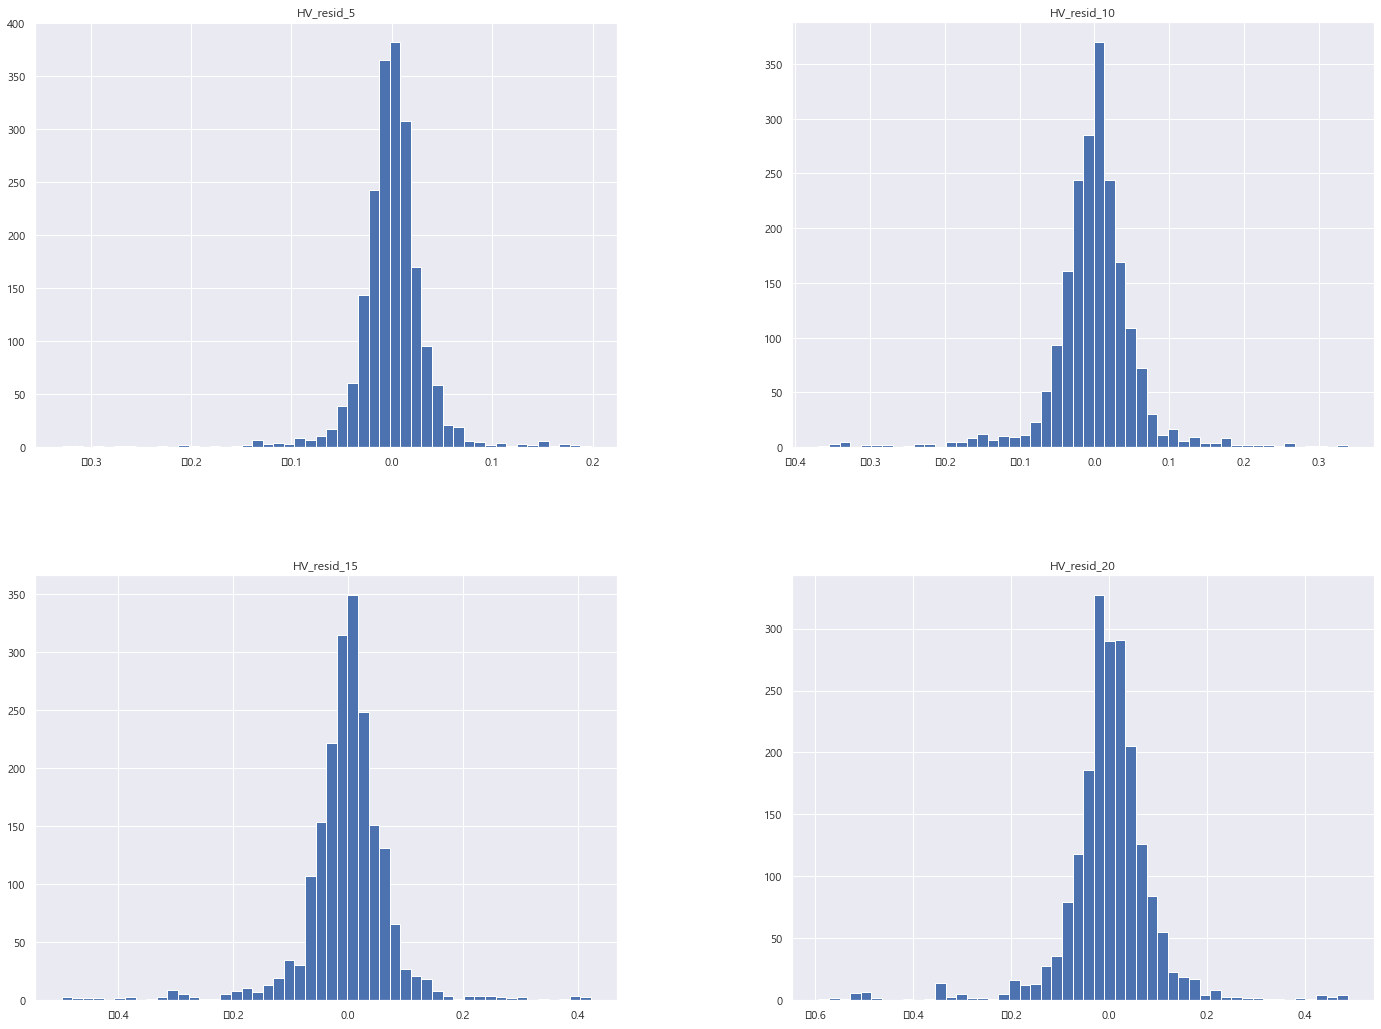

In [30]:
baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].hist(bins=50, figsize=(24, 18))

In [31]:
baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20']

,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20
date,,,,
2003-09-29,-0.127251,-0.139705,-0.161701,-0.184197
2003-09-30,-0.081133,-0.094723,-0.115183,-0.137625
2003-10-01,-0.019628,-0.035527,-0.062418,-0.048270
2003-10-02,-0.020592,-0.033539,-0.067348,-0.045087
2003-10-03,-0.011518,-0.031519,-0.054640,-0.022599
...,...,...,...,...
2011-09-22,0.010775,-0.014364,-0.020938,0.022385
2011-09-23,-0.004545,0.000714,-0.027717,0.016358
2011-09-26,-0.010103,-0.028646,-0.033240,0.009681


In [32]:
resid5 = baseline_hv[['HV_resid_5']]
resid5['class'] = '5'
resid5.columns = ['resid', 'class']
resid5 = resid5[start_date_train:end_date_train]

In [33]:
resid10 = baseline_hv[['HV_resid_10']]
resid10['class'] = '10'
resid10.columns = ['resid', 'class']
resid10 = resid10[start_date_train:end_date_train]

In [34]:
resid15 = baseline_hv[['HV_resid_15']]
resid15['class'] = '15'
resid15.columns = ['resid', 'class']
resid15 = resid15[start_date_train:end_date_train]

In [35]:
resid20 = baseline_hv[['HV_resid_20']]
resid20['class'] = '20'
resid20.columns = ['resid', 'class']
resid20 = resid20[start_date_train:end_date_train]

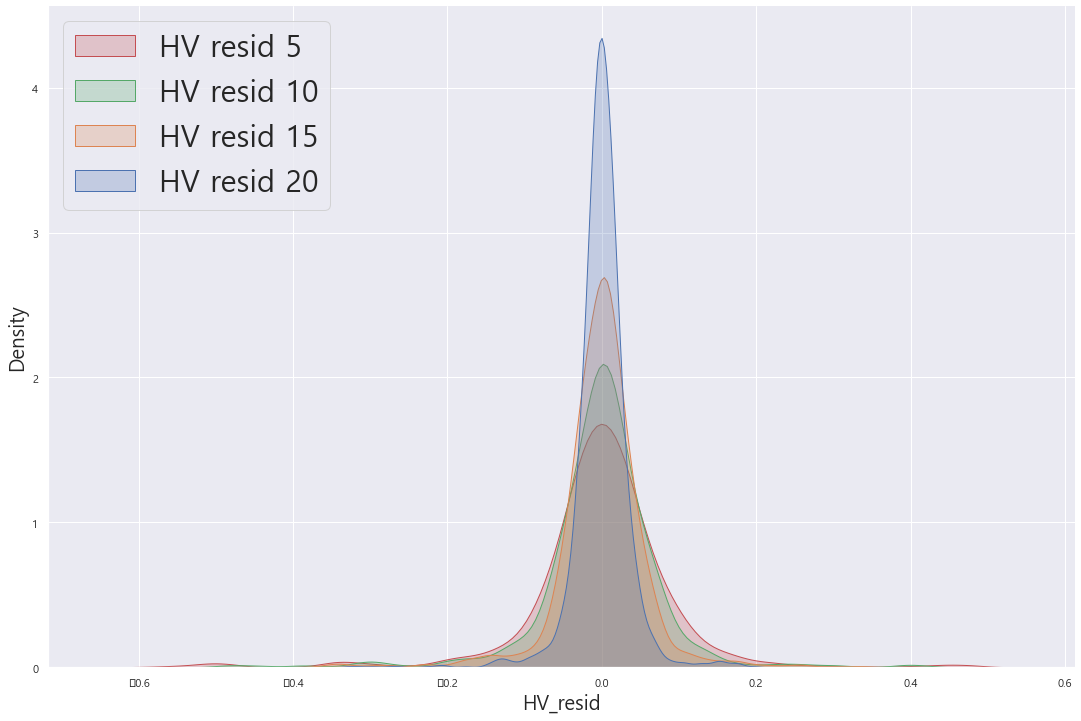

In [36]:
ax = sns.displot(
    data=pd.concat(
    [resid5, resid10, resid15, resid20], axis=0
    ), 
    x='resid', hue='class', kind='kde', height=10, aspect=1.5, fill=True, facet_kws=dict(legend_out=False),
)
plt.xlabel('HV_resid', fontsize=20)     # x축 이름
plt.ylabel('Density', fontsize=20)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.legend(loc='upper left', labels=['HV resid 5', 'HV resid 10', 'HV resid 15', 'HV resid 20'], fontsize=30)
plt.show()

<AxesSubplot:xlabel='date', ylabel='HV'>

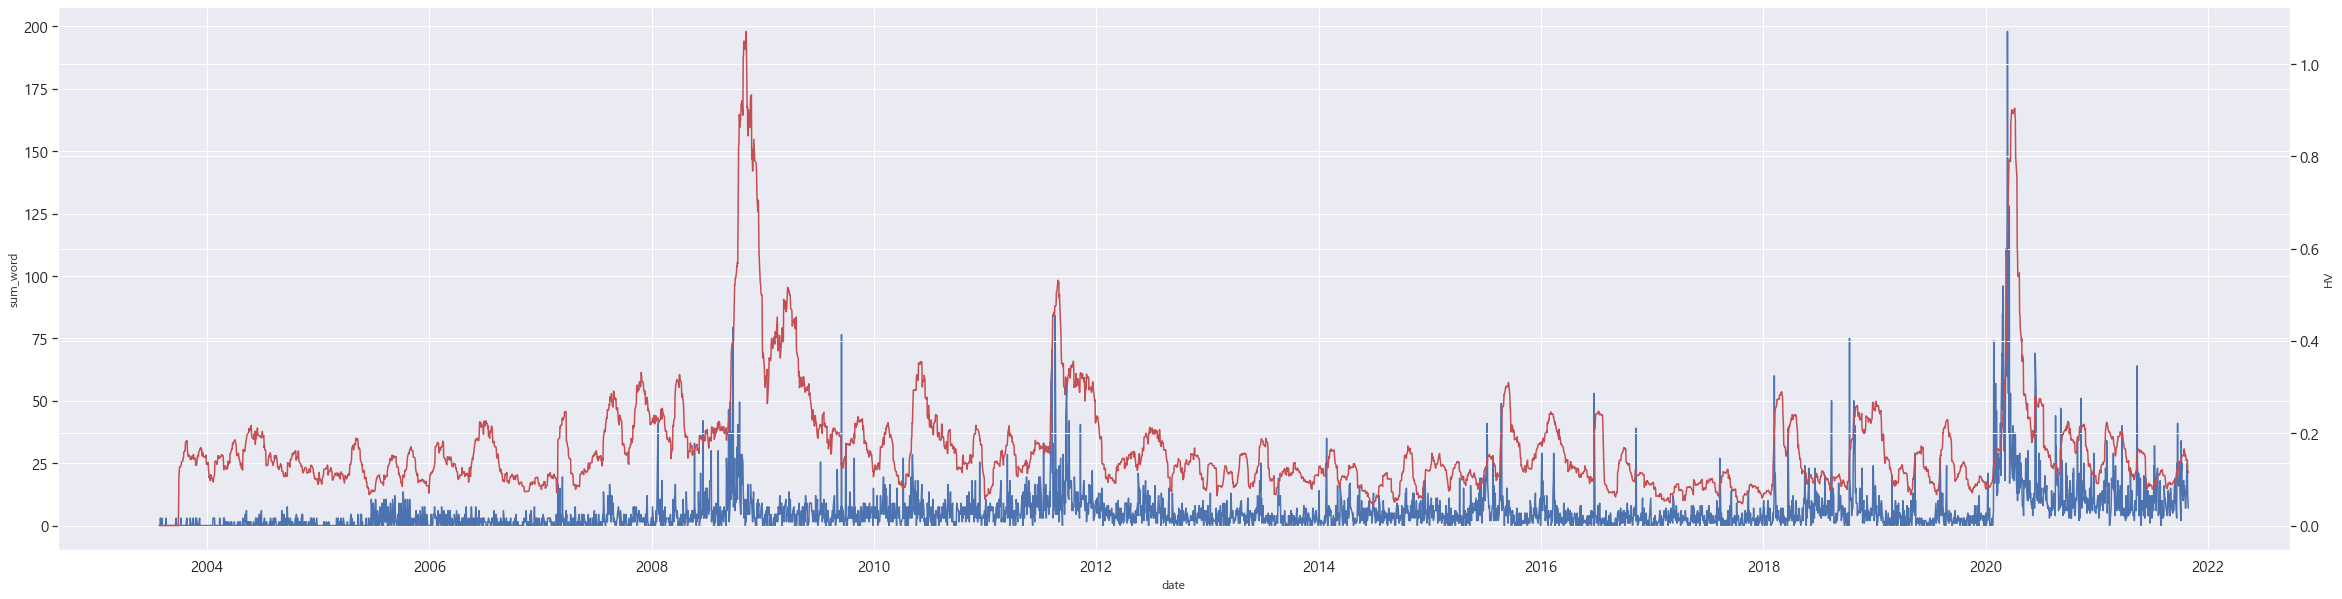

In [37]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=baseline_hv['sum_word'], x=baseline_hv.index)
sns.lineplot(ax=ax2, color='r', y=baseline_hv['HV'], x=baseline_hv.index)

In [38]:
# baseline_hv.to_csv('./baseline_hv.csv')

# 벤치마크 포트폴리오

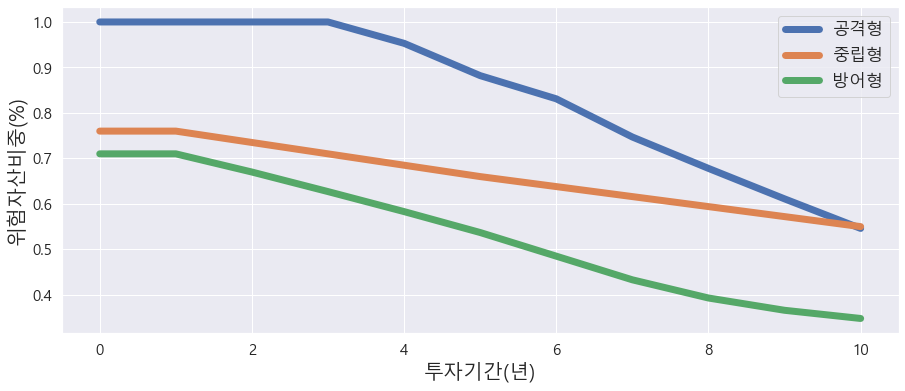

In [39]:
# 10년 벤치마크 글라이드 패스 비중
glide_weight_att = [1.000, 1.000, 1.000, 1.000, .9530, .8820, .8310, .7470, .6780, .6110, .5460]
glide_weight_neu = [.7600, .7600, .7350, .7100, .6850, .6600, .6380, .6160, .5940, .5720, .5500]
glide_weight_def = [.7100, .7100, .6700, .6270, .5830, .5370, .4850, .4330, .3930, .3660, .3480]

# 3년 벤치마크 글라이드 패스 비중
# glide_weight_att = [1.000, 1.000, .8820, .5460]
# glide_weight_neu = [.7600, .7600, .6600, .5500]
# glide_weight_def = [.7100, .7100, .5370, .3480]

f = plt.subplots(figsize=(15, 6))   
sns.lineplot(x=range(len(glide_weight_att)), y=glide_weight_att, lw=7, label='공격형')
sns.lineplot(x=range(len(glide_weight_neu)), y=glide_weight_neu, lw=7, label='중립형')
sns.lineplot(x=range(len(glide_weight_def)), y=glide_weight_def, lw=7, label='방어형')
plt.legend(fontsize=17)                   # 범례 크기
plt.xlabel('투자기간(년)', fontsize=20)     # x축 이름
plt.ylabel('위험자산비중(%)', fontsize=20)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

In [40]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(['2011-09-29', '2012-09-28', '2013-09-30', '2014-09-29','2015-09-29', '2016-09-29', '2017-09-29', '2018-09-28','2019-09-30', '2020-09-29', '2021-08-28'])
    df.drop('RA', axis=1, inplace=True)
    
    return df

In [41]:
# 벤치마크 글라이드 패스
gp_bench_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_bench_att

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2011-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2012-09-28,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2013-09-30,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2014-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2015-09-29,0.047,0.023825,0.023825,0.035737,0.035737,0.23825,0.1906,0.405025
2016-09-29,0.118,0.022050,0.022050,0.033075,0.033075,0.22050,0.1764,0.374850
2017-09-29,0.169,0.020775,0.020775,0.031162,0.031162,0.20775,0.1662,0.353175
2018-09-28,0.253,0.018675,0.018675,0.028012,0.028012,0.18675,0.1494,0.317475
2019-09-30,0.322,0.016950,0.016950,0.025425,0.025425,0.16950,0.1356,0.288150
2020-09-29,0.389,0.015275,0.015275,0.022912,0.022912,0.15275,0.1222,0.259675


In [42]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

bench_att = bt.Strategy(
    'bench_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_att), 
        bt.algos.Rebalance(), 
    ]
)

bench_neu = bt.Strategy(
    'bench_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_neu), 
        bt.algos.Rebalance(), 
    ]
)

bench_def = bt.Strategy(
    'bench_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_def), 
        bt.algos.Rebalance(), 
    ]
)

bench_att_backtest = bt.Backtest(strategy=bench_att, data=data)
bench_neu_backtest = bt.Backtest(strategy=bench_neu, data=data)
bench_def_backtest = bt.Backtest(strategy=bench_def, data=data)

bench_result = bt.run(bench_att_backtest, bench_neu_backtest, bench_def_backtest)
bench_hv = bench_result.prices
bench_hv

,bench_att,bench_neu,bench_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894488,97.729429,97.903722
2011-10-03,94.167331,95.755132,96.086603
2011-10-04,96.395772,97.374284,97.578556
...,...,...,...
2021-09-22,332.846796,280.738820,247.180227
2021-09-23,335.472136,282.759039,247.992161
2021-09-24,334.214005,281.729173,247.241016
2021-09-27,333.795271,281.374060,246.919396


In [43]:
for col in bench_hv.columns:
    bench_hv[col + '_HV']          = bench_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    bench_hv[col + '_HV_pred_5']   = bench_hv[col + '_HV'].shift(-5)
    bench_hv[col + '_HV_pred_10']  = bench_hv[col + '_HV'].shift(-10)
    bench_hv[col + '_HV_pred_15']  = bench_hv[col + '_HV'].shift(-15)
    bench_hv[col + '_HV_pred_20']  = bench_hv[col + '_HV'].shift(-20)
    bench_hv[col + '_HV_resid_5']  = bench_hv[col + '_HV'].diff(-5)
    bench_hv[col + '_HV_resid_10'] = bench_hv[col + '_HV'].diff(-10)
    bench_hv[col + '_HV_resid_15'] = bench_hv[col + '_HV'].diff(-15)
    bench_hv[col + '_HV_resid_20'] = bench_hv[col + '_HV'].diff(-20)

bench_hv = bench_hv[start_date_bt:end_date_bt]
bench_hv

,bench_att,bench_neu,bench_def,bench_att_HV,bench_att_HV_pred_5,bench_att_HV_pred_10,bench_att_HV_pred_15,bench_att_HV_pred_20,bench_att_HV_resid_5,bench_att_HV_resid_10,...,bench_neu_HV_resid_20,bench_def_HV,bench_def_HV_pred_5,bench_def_HV_pred_10,bench_def_HV_pred_15,bench_def_HV_pred_20,bench_def_HV_resid_5,bench_def_HV_resid_10,bench_def_HV_resid_15,bench_def_HV_resid_20
2011-09-29,100.000000,100.000000,100.000000,0.000000,0.360795,0.324120,0.305722,0.329484,-0.360795,-0.324120,...,-0.243648,0.000000,0.240325,0.219152,0.207621,0.225633,-0.240325,-0.219152,-0.207621,-0.225633
2011-09-30,96.894488,97.729429,97.903722,0.246492,0.335629,0.316655,0.303504,0.302691,-0.089136,-0.070162,...,-0.043594,0.166387,0.224012,0.214403,0.206887,0.207246,-0.057625,-0.048017,-0.040501,-0.040859
2011-10-03,94.167331,95.755132,96.086603,0.222310,0.372742,0.323141,0.303095,0.305007,-0.150432,-0.100831,...,-0.065349,0.148699,0.252209,0.218675,0.207005,0.210157,-0.103510,-0.069976,-0.058306,-0.061458
2011-10-04,96.395772,97.374284,97.578556,0.355046,0.352095,0.317429,0.307939,0.318360,0.002951,0.037617,...,0.019174,0.235599,0.238039,0.215160,0.209925,0.219600,-0.002440,0.020439,0.025674,0.015999
2011-10-05,98.063524,98.560755,98.664538,0.358458,0.338130,0.313585,0.300349,0.318001,0.020327,0.044873,...,0.020807,0.237138,0.228638,0.212739,0.204686,0.219951,0.008501,0.024399,0.032452,0.017188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,336.095047,283.306225,248.581924,0.061773,0.065345,0.062773,0.066844,0.074227,-0.003572,-0.001000,...,-0.011705,0.041410,0.045991,0.043357,0.045014,0.048638,-0.004581,-0.001947,-0.003604,-0.007228
2021-08-24,337.308545,284.252201,249.028843,0.061105,0.062106,0.063076,0.061904,0.077043,-0.001000,-0.001970,...,-0.015018,0.041283,0.043730,0.042812,0.041094,0.050837,-0.002447,-0.001529,0.000189,-0.009554
2021-08-25,337.400682,284.297035,248.904544,0.060321,0.063095,0.064273,0.062205,0.082508,-0.002774,-0.003952,...,-0.020631,0.040595,0.044427,0.043018,0.041977,0.052376,-0.003833,-0.002424,-0.001383,-0.011781
2021-08-26,335.678558,282.924285,248.093398,0.061997,0.062579,0.065880,0.066668,0.081637,-0.000582,-0.003883,...,-0.018245,0.041777,0.044334,0.044701,0.045354,0.052211,-0.002557,-0.002924,-0.003577,-0.010434


## 전략별 비교

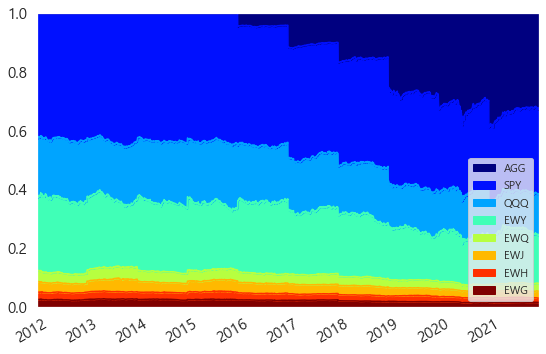

In [44]:
ax = bench_result.get_security_weights(backtest='bench_att').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

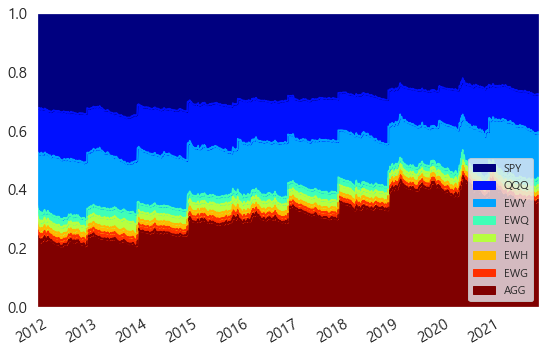

In [45]:
ax = bench_result.get_security_weights(backtest='bench_neu').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

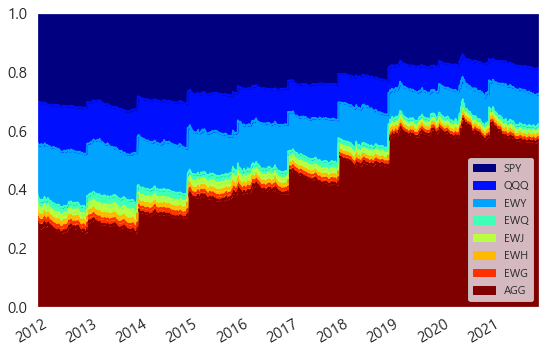

In [46]:
ax = bench_result.get_security_weights(backtest='bench_def').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

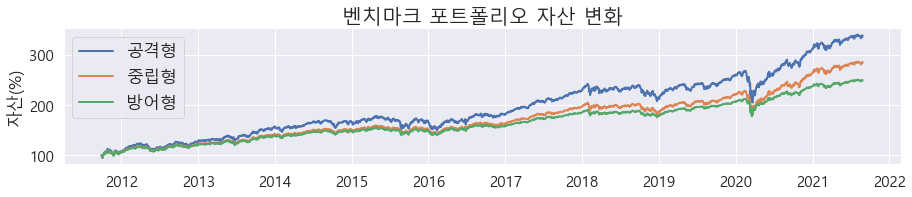

In [47]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.lineplot(y='bench_att', label='공격형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu', label='중립형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def', label='방어형', lw=2, x=bench_hv.index, data=bench_hv)

plt.title('벤치마크 포트폴리오 자산 변화', fontsize=20)
plt.legend(fontsize=17, loc='upper left')                   # 범례 크기
# plt.xlabel('연도(년)', fontsize=20)     # x축 이름
plt.ylabel('자산(%)', fontsize=17)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

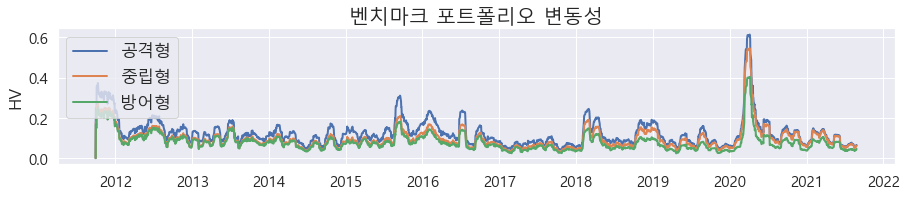

In [48]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.lineplot(y='bench_att_HV', label='공격형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu_HV', label='중립형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def_HV', label='방어형', lw=2, x=bench_hv.index, data=bench_hv)

plt.title('벤치마크 포트폴리오 변동성', fontsize=20)
plt.legend(fontsize=17, loc='upper left')                   # 범례 크기
# plt.xlabel('연도(년)', fontsize=20)     # x축 이름
plt.ylabel('HV', fontsize=17)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

# 변동성 예측 기반 포트폴리오

In [49]:
# 예측 글라이드 패스
gp_pred_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_pred_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_pred_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_pred_att

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2011-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2012-09-28,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2013-09-30,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2014-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2015-09-29,0.047,0.023825,0.023825,0.035737,0.035737,0.23825,0.1906,0.405025
2016-09-29,0.118,0.022050,0.022050,0.033075,0.033075,0.22050,0.1764,0.374850
2017-09-29,0.169,0.020775,0.020775,0.031162,0.031162,0.20775,0.1662,0.353175
2018-09-28,0.253,0.018675,0.018675,0.028012,0.028012,0.18675,0.1494,0.317475
2019-09-30,0.322,0.016950,0.016950,0.025425,0.025425,0.16950,0.1356,0.288150
2020-09-29,0.389,0.015275,0.015275,0.022912,0.022912,0.15275,0.1222,0.259675


In [50]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

pred_att = bt.Strategy(
    'pred_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_att), 
        bt.algos.Rebalance(), 
    ]
)

pred_neu = bt.Strategy(
    'pred_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_neu), 
        bt.algos.Rebalance(), 
    ]
)

pred_def = bt.Strategy(
    'pred_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_def), 
        bt.algos.Rebalance(), 
    ]
)

pred_att_backtest = bt.Backtest(strategy=pred_att, data=data)
pred_neu_backtest = bt.Backtest(strategy=pred_neu, data=data)
pred_def_backtest = bt.Backtest(strategy=pred_def, data=data)

pred_result = bt.run(pred_att_backtest, pred_neu_backtest, pred_def_backtest)
pred_hv = pred_result.prices
pred_hv

,pred_att,pred_neu,pred_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894488,97.729429,97.903722
2011-10-03,94.167331,95.755132,96.086603
2011-10-04,96.395772,97.374284,97.578556
...,...,...,...
2021-09-22,332.846796,280.738820,247.180227
2021-09-23,335.472136,282.759039,247.992161
2021-09-24,334.214005,281.729173,247.241016
2021-09-27,333.795271,281.374060,246.919396


In [51]:
pred = pd.read_csv('./pred_df_final.csv', index_col='date')
pred.index = pd.to_datetime(pred.index)
pred

,pred
date,
2011-10-27,0.268389
2011-10-28,0.287141
2011-10-31,0.275389
2011-11-01,0.278015
2011-11-02,0.290211
...,...
2021-09-22,0.123434
2021-09-23,0.120778
2021-09-24,0.126407


In [52]:
pred_hv = pd.merge(pred_hv, pred, how='left', left_index=True, right_index=True)
pred_hv

,pred_att,pred_neu,pred_def,pred
2011-09-28,100.000000,100.000000,100.000000,NaN
2011-09-29,100.000000,100.000000,100.000000,NaN
2011-09-30,96.894488,97.729429,97.903722,NaN
2011-10-03,94.167331,95.755132,96.086603,NaN
2011-10-04,96.395772,97.374284,97.578556,NaN
...,...,...,...,...
2021-09-22,332.846796,280.738820,247.180227,0.123434
2021-09-23,335.472136,282.759039,247.992161,0.120778
2021-09-24,334.214005,281.729173,247.241016,0.126407
2021-09-27,333.795271,281.374060,246.919396,0.124015


In [53]:
for col in pred_hv.columns:
    pred_hv[col + '_HV']          = pred_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    pred_hv[col + '_HV_pred_5']   = pred_hv['pred'].shift(-5)
    pred_hv[col + '_HV_pred_10']  = pred_hv['pred'].shift(-10)
    pred_hv[col + '_HV_pred_15']  = pred_hv['pred'].shift(-15)
    pred_hv[col + '_HV_pred_20']  = pred_hv['pred'].shift(-20)
    pred_hv[col + '_HV_resid_5']  = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_5']
    pred_hv[col + '_HV_resid_10'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_10'] 
    pred_hv[col + '_HV_resid_15'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_15'] 
    pred_hv[col + '_HV_resid_20'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_20'] 

pred_hv = pred_hv[start_date_bt:end_date_bt]
pred_hv

,pred_att,pred_neu,pred_def,pred,pred_att_HV,pred_att_HV_pred_5,pred_att_HV_pred_10,pred_att_HV_pred_15,pred_att_HV_pred_20,pred_att_HV_resid_5,...,pred_def_HV_resid_20,pred_HV,pred_HV_pred_5,pred_HV_pred_10,pred_HV_pred_15,pred_HV_pred_20,pred_HV_resid_5,pred_HV_resid_10,pred_HV_resid_15,pred_HV_resid_20
2011-09-29,100.000000,100.000000,100.000000,NaN,0.000000,NaN,NaN,NaN,0.268389,NaN,...,-0.268389,NaN,NaN,NaN,NaN,0.268389,NaN,NaN,NaN,NaN
2011-09-30,96.894488,97.729429,97.903722,NaN,0.246492,NaN,NaN,NaN,0.287141,NaN,...,-0.120754,NaN,NaN,NaN,NaN,0.287141,NaN,NaN,NaN,NaN
2011-10-03,94.167331,95.755132,96.086603,NaN,0.222310,NaN,NaN,NaN,0.275389,NaN,...,-0.126689,NaN,NaN,NaN,NaN,0.275389,NaN,NaN,NaN,NaN
2011-10-04,96.395772,97.374284,97.578556,NaN,0.355046,NaN,NaN,NaN,0.278015,NaN,...,-0.042415,NaN,NaN,NaN,NaN,0.278015,NaN,NaN,NaN,NaN
2011-10-05,98.063524,98.560755,98.664538,NaN,0.358458,NaN,NaN,NaN,0.290211,NaN,...,-0.053073,NaN,NaN,NaN,NaN,0.290211,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,336.095047,283.306225,248.581924,0.078823,0.061773,0.091057,0.089805,0.097440,0.115225,-0.029284,...,-0.073815,0.546818,0.091057,0.089805,0.097440,0.115225,0.455761,0.457013,0.449377,0.431592
2021-08-24,337.308545,284.252201,249.028843,0.087170,0.061105,0.091017,0.090279,0.096687,0.123434,-0.029912,...,-0.082151,0.688093,0.091017,0.090279,0.096687,0.123434,0.597075,0.597814,0.591405,0.564659
2021-08-25,337.400682,284.297035,248.904544,0.088121,0.060321,0.090356,0.092548,0.094851,0.120778,-0.030035,...,-0.080184,0.681463,0.090356,0.092548,0.094851,0.120778,0.591107,0.588916,0.586612,0.560685
2021-08-26,335.678558,282.924285,248.093398,0.088606,0.061997,0.090799,0.095142,0.092202,0.126407,-0.028802,...,-0.084630,0.669415,0.090799,0.095142,0.092202,0.126407,0.578616,0.574273,0.577213,0.543008


# 리밸런싱 함수

In [54]:
def getOutSignal(a, b):
    if a <= b:
        result_sig = 1
    else:
        result_sig = 0
    return result_sig

def getOutDate(a, b):
    if (a == 1) & (b ==0):
        result_out = 1
    else:
        result_out = 0
    return result_out

def getFillDate(a, b):
    if (a == 1) & (b == 0):
        result_fill = 'out'
    elif (a == 0) & (b == 1):
        result_fill = 'in'
    else:
        result_fill = np.nan
    return result_fill

def getRebalancedGlidePath(
    portfolio_hv, glide_path, 
    resid_diff, out_multiple, in_multiple, rebalance_weight, 
    hv_resid_mean, hv_resid_std, 
):
    
    df = portfolio_hv.copy()
    df.columns = ['portfolio', 'HV', 'HV_resid_5', 'HV_resid_10', 'HV_resid_15', 'HV_resid_20']
    
    if resid_diff == 5:
        df = df[['portfolio', 'HV', 'HV_resid_5']]
        hv_resid_mean = hv_resid_mean[0]
        hv_resid_std  = hv_resid_std[0]
    elif resid_diff == 10:
        df = df[['portfolio', 'HV', 'HV_resid_10']]
        hv_resid_mean = hv_resid_mean[1]
        hv_resid_std  = hv_resid_std[1]
    elif resid_diff == 15:
        df = df[['portfolio', 'HV', 'HV_resid_15']]
        hv_resid_mean = hv_resid_mean[2]
        hv_resid_std  = hv_resid_std[2]
    elif resid_diff == 20:
        df = df[['portfolio', 'HV', 'HV_resid_20']]
        hv_resid_mean = hv_resid_mean[3]
        hv_resid_std  = hv_resid_std[3]
    else:
        print('invalid resid diff')
    df.columns = ['portfolio', 'HV', 'HV_resid']
    
    gp = glide_path.copy()
    
    # 기존 글라이드 패스와 리밸런싱 일자를 구분하기 위한 컬럼
    gp['class'] = 'gp'
    
    # 리밸런싱 시그널
    df['HV_resid_signal'] = hv_resid_mean - out_multiple * hv_resid_std
    df['Out_signal'] = df.apply(lambda x: getOutSignal(x['HV_resid'], x['HV_resid_signal']), axis=1)
    df['Out_signal_shift'] = df['Out_signal'].shift(1)
    
    # 위험자산의 비중을 낮추는 일자
    df['Out_date'] = df.apply(lambda x: getOutDate(x['Out_signal'], x['Out_signal_shift']), axis=1)
    
    # 위험자산의 비중을 이전의 글라이드 패스로 복구할 일자
    df.reset_index(inplace=True)
    out_idx = df[df['Out_date'] == 1].index
    rb_idx  = []
    in_idx  = []
    for out_date_idx in out_idx:
        idx = out_date_idx
        try:
            while df.iloc[idx, 3] <= (hv_resid_mean + in_multiple * hv_resid_std):
                rb_idx.append(idx)
                idx = idx + 1
            in_idx.append(idx)
        except:
            pass
    df['In_date'] = 0
    df.iloc[in_idx, -1] = 1
    
    df['Rebalance'] = 0
    df.iloc[rb_idx, -1] = 1
    
    df['Rebalance_shift'] = df['Rebalance'].shift(1)
    df['Fill_date'] = df.apply(lambda x: getFillDate(x['Rebalance'], x['Rebalance_shift']), axis=1)
    
    df.set_index('index', inplace=True)
    df['class'] = np.nan
    df.iloc[out_idx, -1] = 'out'
    df.iloc[in_idx,  -1] = 'in'
    
    history = df.copy()
    
    
    # 기존 글라이드 패스에 리밸런싱 일자 추가
    gp = pd.concat([gp, df[df['class'].notna()][['class']]], axis=0).sort_index()
    gp.reset_index(inplace=True)
    i = 0
    drop_cnt = 0
    while i < gp.shape[0] + drop_cnt:
        if gp.loc[i, 'class'] == 'out':
            gp.loc[i, 'EWG'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWG']
            gp.loc[i, 'EWH'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWH']
            gp.loc[i, 'EWJ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWJ']
            gp.loc[i, 'EWQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWQ']
            gp.loc[i, 'EWY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWY']
            gp.loc[i, 'QQQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'QQQ']
            gp.loc[i, 'SPY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'SPY']
            gp.loc[i, 'AGG'] = 1 - gp.loc[i, 'EWG':'SPY'].sum()
        elif gp.loc[i, 'class'] == 'in':
            if gp.loc[i - 1, 'class'] == 'gp':
                gp.loc[i, 'EWG'] = gp.loc[i - 1, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 1, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 1, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 1, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 1, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 1, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 1, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 1, 'AGG']
                gp.drop(axis=0, index=[i - 1], inplace=True)
                drop_cnt = drop_cnt + 1
            elif gp.loc[i - 1, 'class'] == 'out':
                gp.loc[i, 'EWG'] = gp.loc[i - 2, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 2, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 2, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 2, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 2, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 2, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 2, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 2, 'AGG']
        elif gp.loc[i, 'class'] == 'gp':
            pass
        i = i + 1
    gp.set_index('index', inplace=True)
    
    
    return gp, history

# 리밸런싱 백테스트

In [55]:
# 고객에게 제안 가능한 조건
resid_diff = 20
out_multiple = 0.8
in_multiple  = 0
rebalance_weight = 0.9

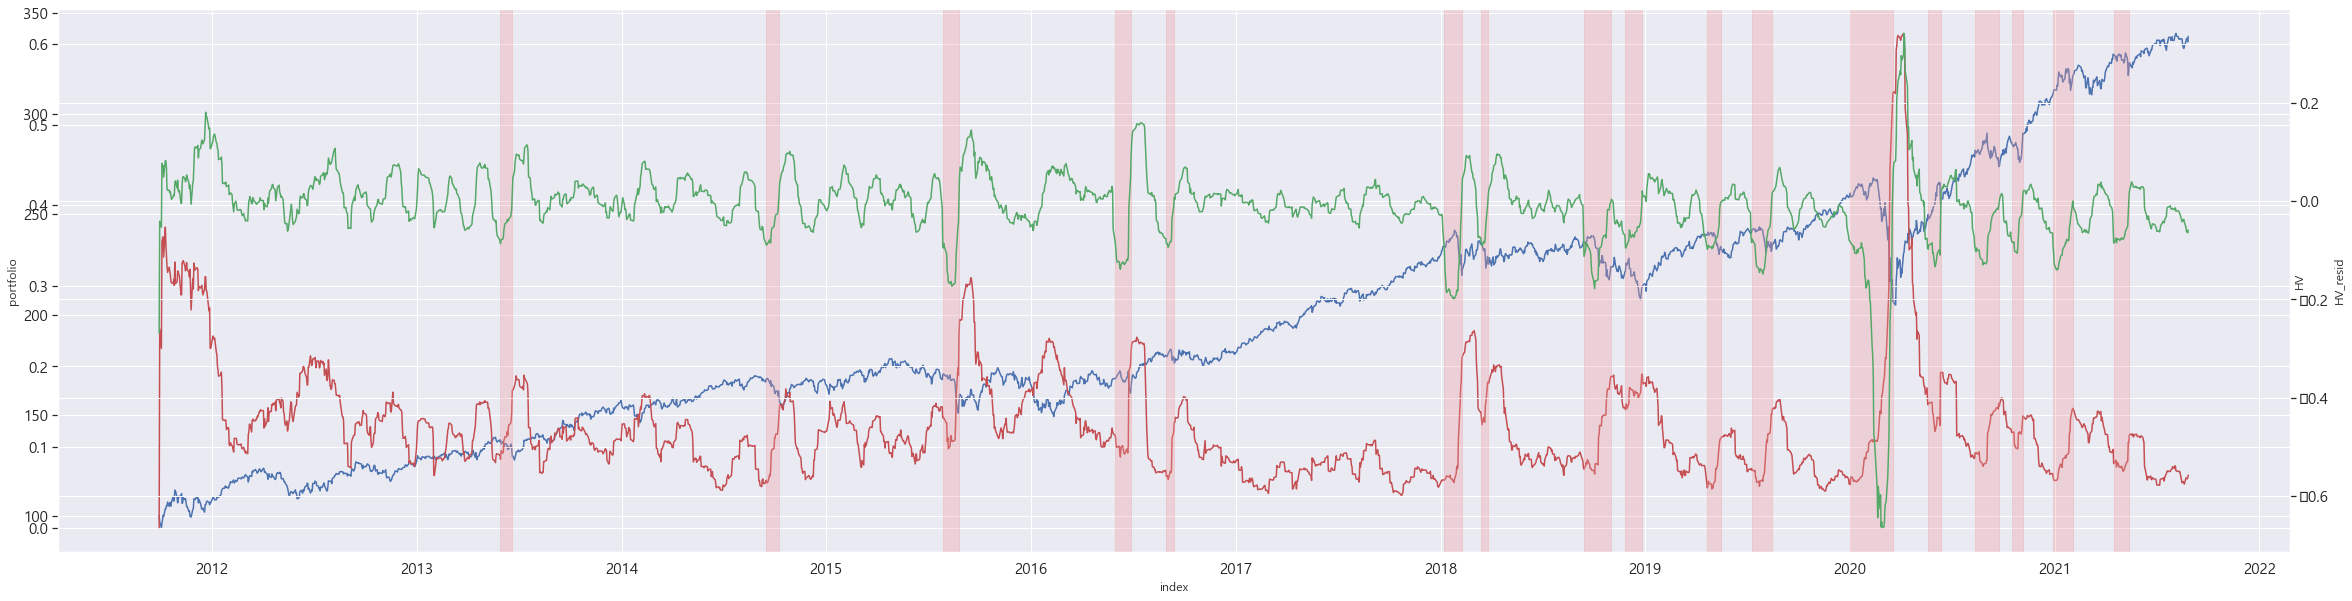

In [56]:
# 공격형 글라이드 패스 리밸런싱
gp_bt_att, history_bt_att = getRebalancedGlidePath(
    pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
    gp_pred_att, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_att['portfolio'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_att['HV'], x=history_bt_att.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_att['HV_resid'], x=history_bt_att.index)

out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
for i, j in zip(out_idx_att, in_idx_att):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [57]:
# # 공격형 글라이드 패스 리밸런싱 : 특정 구간
# gp_bt_att, history_bt_att = getRebalancedGlidePath(
#     pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
#     gp_pred_att, 
#     resid_diff=resid_diff, out_multiple=out_multiple, 
#     in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
#     hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
# )
# history_bt_att = history_bt_att['2019-06-30':'2021-06-29']

# fig, ax1 = plt.subplots(figsize=(40, 10))
# ax2 = ax1.twinx()
# sns.lineplot(ax=ax1, color='b', lw=3, y=history_bt_att['portfolio'], x=history_bt_att.index)
# sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_att['HV'], x=history_bt_att.index)
# sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_att['HV_resid'], x=history_bt_att.index)

# out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
# in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
# for i, j in zip(out_idx_att, in_idx_att):
#     ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)

# plt.rc(['xtick', 'ytick'], labelsize=20)
# plt.legend(fontsize=(40), labels=['HV', 'HV_resid', 'Rebalanced'])

# ax1.set_ylabel('Portfolio', fontsize=30)
# ax2.set_ylabel('HV', fontsize=30)
# plt.rc(['xtick', 'ytick'], labelsize=25)
# plt.show()

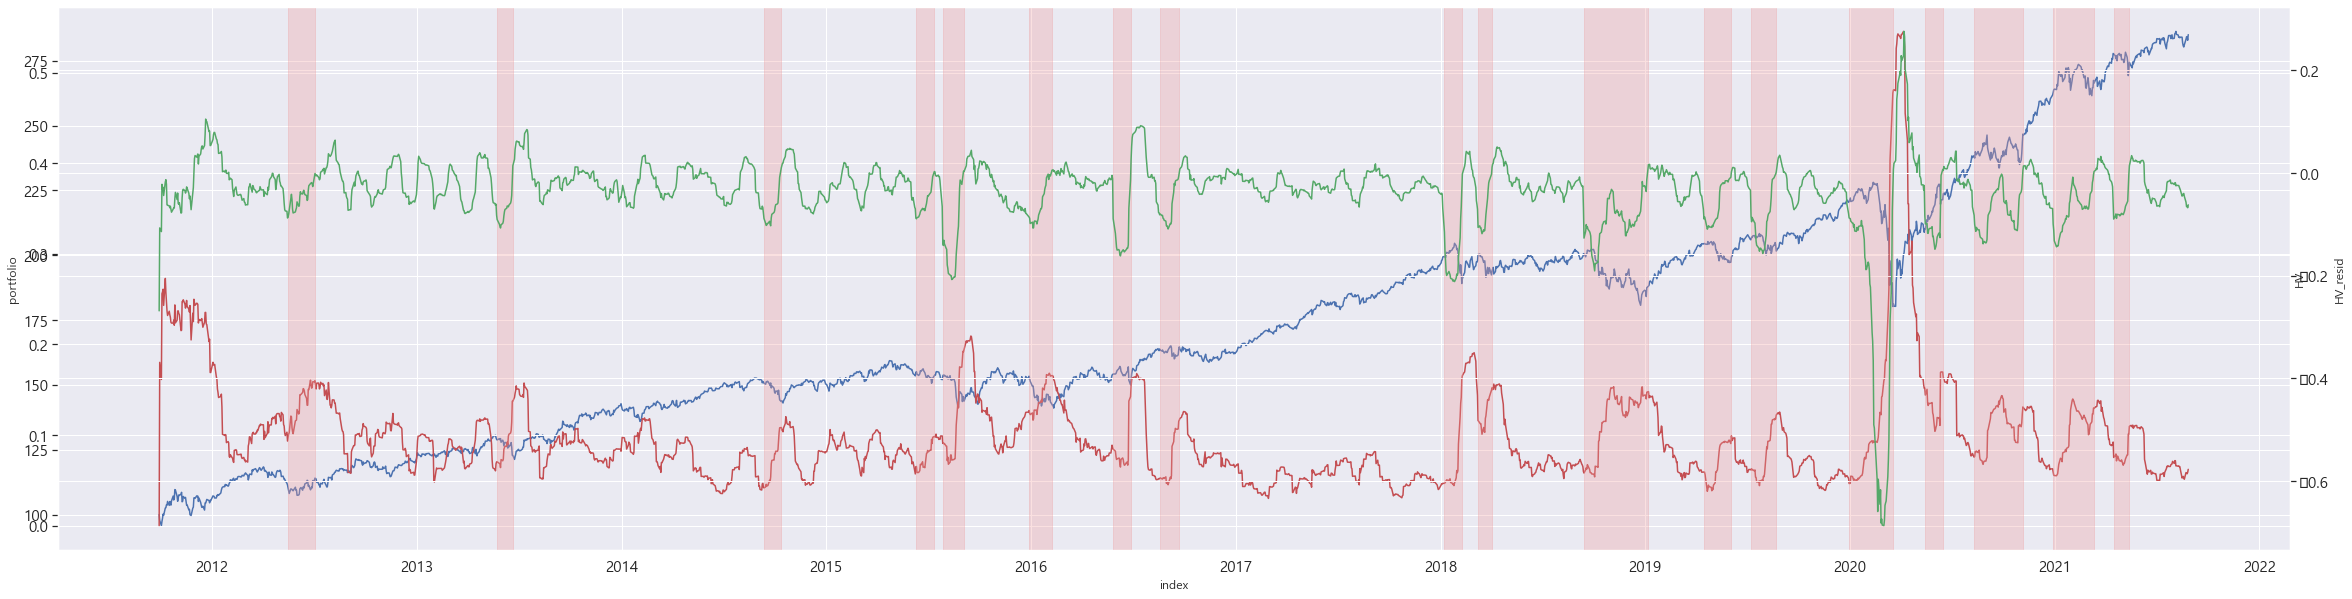

In [58]:
# 중립형 글라이드 패스 리밸런싱
gp_bt_neu, history_bt_neu = getRebalancedGlidePath(
    pred_hv[['pred_neu', 'pred_neu_HV', 'pred_neu_HV_resid_5', 'pred_neu_HV_resid_10', 'pred_neu_HV_resid_15', 'pred_neu_HV_resid_20']], 
    gp_pred_neu, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_neu['portfolio'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_neu['HV'], x=history_bt_neu.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_neu['HV_resid'], x=history_bt_neu.index)

out_idx_neu = history_bt_neu[history_bt_neu['Fill_date'] == 'out'].index
in_idx_neu  = history_bt_neu[history_bt_neu['Fill_date'] == 'in'].index
for i, j in zip(out_idx_neu, in_idx_neu):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

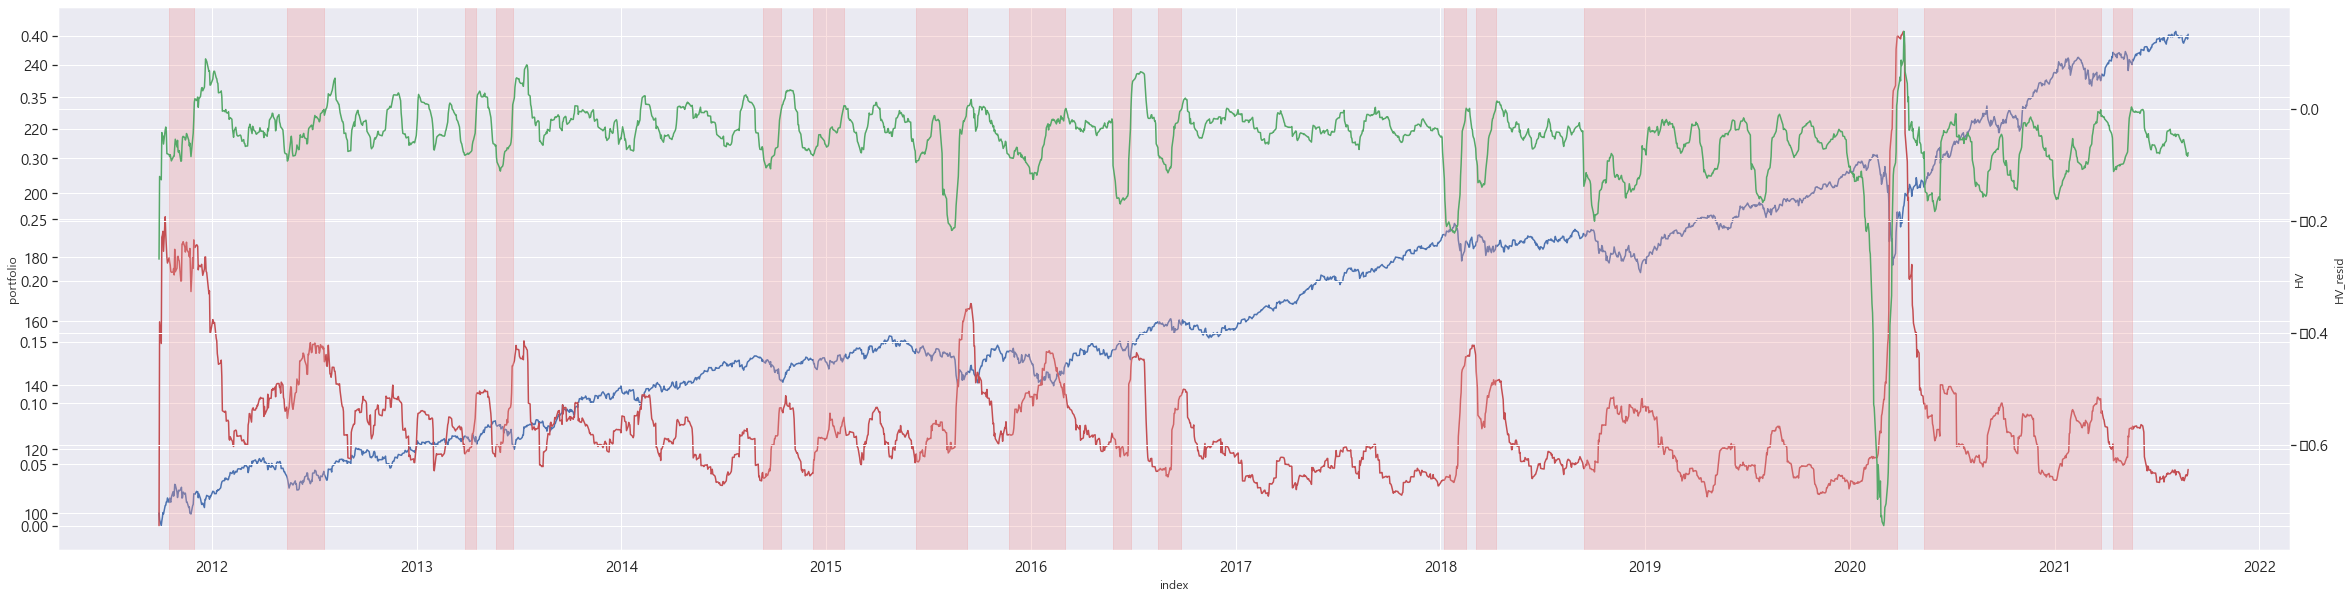

In [59]:
# 방어형 글라이드 패스 리밸런싱
gp_bt_def, history_bt_def = getRebalancedGlidePath(
    pred_hv[['pred_def', 'pred_def_HV', 'pred_def_HV_resid_5', 'pred_def_HV_resid_10', 'pred_def_HV_resid_15', 'pred_def_HV_resid_20']], 
    gp_bench_def, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_def['portfolio'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_def['HV'], x=history_bt_def.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_def['HV_resid'], x=history_bt_def.index)

out_idx_def = history_bt_def[history_bt_def['Fill_date'] == 'out'].index
in_idx_def  = history_bt_def[history_bt_def['Fill_date'] == 'in'].index
for i, j in zip(out_idx_def, in_idx_def):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [60]:
# 전략별 리밸런싱 횟수
print('공격형 : ', len(out_idx_att))
print('중립형 : ', len(out_idx_neu))
print('방어형 : ', len(out_idx_def))

공격형 :  17
중립형 :  18
방어형 :  16


In [61]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

bt_att = bt.Strategy(
    'bt_att', 
    algos=[
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_neu = bt.Strategy(
    'bt_neu', 
    algos=[
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_neu.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_def = bt.Strategy(
    'bt_def', 
    algos=[
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_def.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_att_backtest = bt.Backtest(strategy=bt_att, data=data)
bt_neu_backtest = bt.Backtest(strategy=bt_neu, data=data)
bt_def_backtest = bt.Backtest(strategy=bt_def, data=data)

bt_result = bt.run(bt_att_backtest, bt_neu_backtest, bt_def_backtest)
bt_hv = bt_result.prices
bt_hv

,bt_att,bt_neu,bt_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894488,97.729429,97.903722
2011-10-03,94.167331,95.755132,96.086603
2011-10-04,96.395772,97.374284,97.578556
...,...,...,...
2021-08-23,597.562784,380.584576,259.300739
2021-08-24,596.958437,380.028975,258.927963
2021-08-25,595.947580,379.308901,258.437073
2021-08-26,595.714417,379.340214,258.459158


# 모든 경우의 수

In [62]:
# data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

# rb_bt_results = []
# rows = []

# for resid_diff in [10, 15, 20]:
#     for out_multiple in [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]:
#         for rebalance_weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            
#             att_row = []
#             neu_row = []
#             def_row = []
            
#             gp_att, history_att = getRebalancedGlidePath(
#                 pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
#                 gp_pred_att, 
#                 resid_diff=resid_diff, out_multiple=out_multiple, 
#                 in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
#                 hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
#             )
#             gp_neu, history_neu = getRebalancedGlidePath(
#                 pred_hv[['pred_neu', 'pred_neu_HV', 'pred_neu_HV_resid_5', 'pred_neu_HV_resid_10', 'pred_neu_HV_resid_15', 'pred_neu_HV_resid_20']], 
#                 gp_pred_neu, 
#                 resid_diff=resid_diff, out_multiple=out_multiple, 
#                 in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
#                 hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
#             )
#             gp_def, history_def = getRebalancedGlidePath(
#                 pred_hv[['pred_def', 'pred_def_HV', 'pred_def_HV_resid_5', 'pred_def_HV_resid_10', 'pred_def_HV_resid_15', 'pred_def_HV_resid_20']], 
#                 gp_pred_def, 
#                 resid_diff=resid_diff, out_multiple=out_multiple, 
#                 in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
#                 hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
#             )
            
#             att = bt.Strategy(
#                 'att', 
#                 algos=[
#                     bt.algos.
#                     bt.algos.SelectAll(), 
#                     bt.algos.WeighTarget(gp_att.drop('class', axis=1)), 
#                     bt.algos.Rebalance(), 
#                 ]
#             )
#             neu = bt.Strategy(
#                 'neu', 
#                 algos=[
#                     bt.algos.
#                     bt.algos.SelectAll(), 
#                     bt.algos.WeighTarget(gp_neu.drop('class', axis=1)), 
#                     bt.algos.Rebalance(), 
#                 ]
#             )
#             deff = bt.Strategy(
#                 'deff', 
#                 algos=[
#                     bt.algos.
#                     bt.algos.SelectAll(), 
#                     bt.algos.WeighTarget(gp_def.drop('class', axis=1)), 
#                     bt.algos.Rebalance(), 
#                 ]
#             )
            
#             att_backtest = bt.Backtest(strategy=att, data=data)
#             neu_backtest = bt.Backtest(strategy=neu, data=data)
#             def_backtest = bt.Backtest(strategy=deff, data=data)
#             rb_bt_result = bt.run(att_backtest, neu_backtest, def_backtest)
#             rb_bt_results.append(rb_bt_result)
#             rb_bt_hv = rb_bt_result.prices
            
#             att_row.append('att')
#             att_row.append(rb_bt_hv.iloc[-1, 0])
#             att_row.append(gp_att[gp_att['class'] == 'out'].shape[0])
#             att_row.append(resid_diff)
#             att_row.append(out_multiple)
#             att_row.append(rebalance_weight)
#             rows.append(att_row)
            
#             neu_row.append('neu')
#             neu_row.append(rb_bt_hv.iloc[-1, 1])
#             neu_row.append(gp_neu[gp_neu['class'] == 'out'].shape[0])
#             neu_row.append(resid_diff)
#             neu_row.append(out_multiple)
#             neu_row.append(rebalance_weight)
#             rows.append(neu_row)
            
#             def_row.append('deff')
#             def_row.append(rb_bt_hv.iloc[-1, 2])
#             def_row.append(gp_def[gp_def['class'] == 'out'].shape[0])
#             def_row.append(resid_diff)
#             def_row.append(out_multiple)
#             def_row.append(rebalance_weight)
#             rows.append(def_row)

# rb_bt_stats = pd.DataFrame(rows, columns=['class', 'return', 'rb_count', 'resid_diff', 'out_multiple', 'rebalance_weight'])
# rb_bt_stats

In [63]:
# rb_bt_stats.to_csv('./rb_scatter.csv', index=False)

In [64]:
rb_bt_stats = pd.read_csv('./rb_bt_stats.csv')
rb_bt_stats.head()

,class,return,rb_count,resid_diff,out_multiple,rebalance_weight
0,att,335.162329,91,10,0.2,0.1
1,neu,264.986305,89,10,0.2,0.1
2,deff,239.121538,53,10,0.2,0.1
3,att,328.060406,91,10,0.2,0.2
4,neu,248.547225,89,10,0.2,0.2


In [65]:
len(rb_bt_results)

NameError: name 'rb_bt_results' is not defined

In [66]:
rb_bt_stats[(rb_bt_stats['resid_diff'] == 20) & (rb_bt_stats['out_multiple'] == 0.8) & (rb_bt_stats['rebalance_weight'] == 0.9)]

,class,return,rb_count,resid_diff,out_multiple,rebalance_weight
537,att,597.641773,20,20,0.8,0.9
538,neu,380.390367,25,20,0.8,0.9
539,deff,259.173220,34,20,0.8,0.9


In [67]:
rb_bt_stats.describe()

,return,rb_count,resid_diff,out_multiple,rebalance_weight
count,567.000000,567.000000,567.000000,567.000000,567.000000
mean,278.638124,60.333333,15.000000,0.528571,0.500000
std,84.554864,24.276019,4.086088,0.237542,0.258427
min,154.961747,19.000000,10.000000,0.200000,0.100000
25%,212.229593,40.000000,10.000000,0.300000,0.300000
50%,256.011947,62.000000,15.000000,0.500000,0.500000
75%,345.950895,77.000000,20.000000,0.800000,0.700000
max,597.641773,112.000000,20.000000,0.900000,0.900000


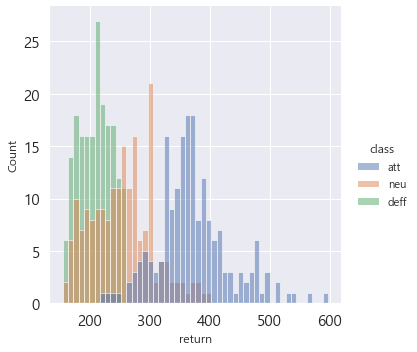

In [68]:
sns.displot(data=rb_bt_stats, x='return', hue='class', bins=50)

In [69]:
rb_bt_stats.groupby('class').mean().sort_values('return', ascending=False)

,return,rb_count,resid_diff,out_multiple,rebalance_weight
class,,,,,
att,372.373226,46.952381,15.0,0.528571,0.5
neu,254.231903,69.190476,15.0,0.528571,0.5
deff,209.309244,64.857143,15.0,0.528571,0.5


In [70]:
rb_bt_stats.groupby('resid_diff').mean().sort_values('return', ascending=False)

,return,rb_count,out_multiple,rebalance_weight
resid_diff,,,,
20,316.403328,49.095238,0.528571,0.5
15,270.339814,58.428571,0.528571,0.5
10,249.171232,73.476190,0.528571,0.5


In [71]:
rb_bt_stats.groupby(by=['class', 'resid_diff'], sort='return').mean()

return   rb_count  out_multiple  rebalance_weight
class resid_diff                                                       
att   10          328.541566  57.142857      0.528571               0.5
      15          363.744525  43.857143      0.528571               0.5
      20          424.833588  39.857143      0.528571               0.5
deff  10          198.224086  73.428571      0.528571               0.5
      15          202.002918  65.857143      0.528571               0.5
      20          227.700729  55.285714      0.528571               0.5
neu   10          220.748043  89.857143      0.528571               0.5
      15          245.271999  65.571429      0.528571               0.5
      20          296.675666  52.142857      0.528571               0.5

In [72]:
rb_bt_stats.groupby('out_multiple').mean().sort_values('return', ascending=False)

,return,rb_count,resid_diff,rebalance_weight
out_multiple,,,,
0.9,315.923904,32.888889,15.0,0.5
0.8,312.587157,42.000000,15.0,0.5
0.6,285.024838,60.000000,15.0,0.5
0.5,267.472192,66.888889,15.0,0.5
0.2,257.358168,72.555556,15.0,0.5
0.4,256.843765,73.222222,15.0,0.5
0.3,255.256848,74.777778,15.0,0.5


In [73]:
rb_bt_stats.groupby(by=['class', 'out_multiple'], sort='return').mean()

return   rb_count  resid_diff  rebalance_weight
class out_multiple                                                     
att   0.2           332.554843  73.666667        15.0               0.5
      0.3           336.366109  70.000000        15.0               0.5
      0.4           344.931364  57.666667        15.0               0.5
      0.5           371.206401  47.666667        15.0               0.5
      0.6           403.760225  34.000000        15.0               0.5
      0.8           420.130188  24.666667        15.0               0.5
      0.9           397.663453  21.000000        15.0               0.5
deff  0.2           203.909973  60.333333        15.0               0.5
      0.3           203.839542  64.666667        15.0               0.5
      0.4           205.173198  73.333333        15.0               0.5
      0.5           196.079980  73.333333        15.0               0.5
      0.6           198.754033  79.666667        15.0               0.5
      0.8           217.449433  58.000000        15.0               0.5
      0.9           239.958550  44.666667        15.0               0.5
neu   0.2           235.609688  83.666667        15.0               0.5
      0.3           225.564893  89.666667        15.0               0.5
      0.4           220.426732  88.666667        15.0               0.5
      0.5           235.130194  79.666667        15.0               0.5
      0.6           252.560254  66.333333        15.0               0.5
      0.8           300.181850  43.333333        15.0               0.5
      0.9           310.149708  33.000000        15.0               0.5

In [74]:
rb_bt_stats.groupby('rebalance_weight').mean().sort_values('return', ascending=False)

,return,rb_count,resid_diff,out_multiple
rebalance_weight,,,,
0.1,287.142384,60.333333,15.0,0.528571
0.2,284.165896,60.333333,15.0,0.528571
0.3,281.914597,60.333333,15.0,0.528571
0.4,279.998065,60.333333,15.0,0.528571
0.5,278.234668,60.333333,15.0,0.528571
0.6,276.542148,60.333333,15.0,0.528571
0.7,274.883187,60.333333,15.0,0.528571
0.8,273.243793,60.333333,15.0,0.528571
0.9,271.618380,60.333333,15.0,0.528571


In [75]:
rb_bt_stats[(rb_bt_stats['out_multiple'] > 0.7) & (rb_bt_stats['resid_diff'] > 10)].groupby('rebalance_weight').mean().sort_values('return', ascending=False)

,return,rb_count,resid_diff,out_multiple
rebalance_weight,,,,
0.9,356.516197,29.0,17.5,0.85
0.8,351.514054,29.0,17.5,0.85
0.7,345.915804,29.0,17.5,0.85
0.6,339.729865,29.0,17.5,0.85
0.5,332.960759,29.0,17.5,0.85
0.4,325.643234,29.0,17.5,0.85
0.3,317.803837,29.0,17.5,0.85
0.2,309.557211,29.0,17.5,0.85
0.1,301.092579,29.0,17.5,0.85


In [76]:
rb_bt_stats[(rb_bt_stats['out_multiple'] > 0.7) & (rb_bt_stats['resid_diff'] > 10) & (rb_bt_stats['rebalance_weight'] == 0.9)].groupby(by=['class'], sort='return').mean()

,return,rb_count,resid_diff,out_multiple,rebalance_weight
class,,,,,
att,481.063322,20.25,17.5,0.85,0.9
deff,243.083033,38.00,17.5,0.85,0.9
neu,345.402236,28.75,17.5,0.85,0.9


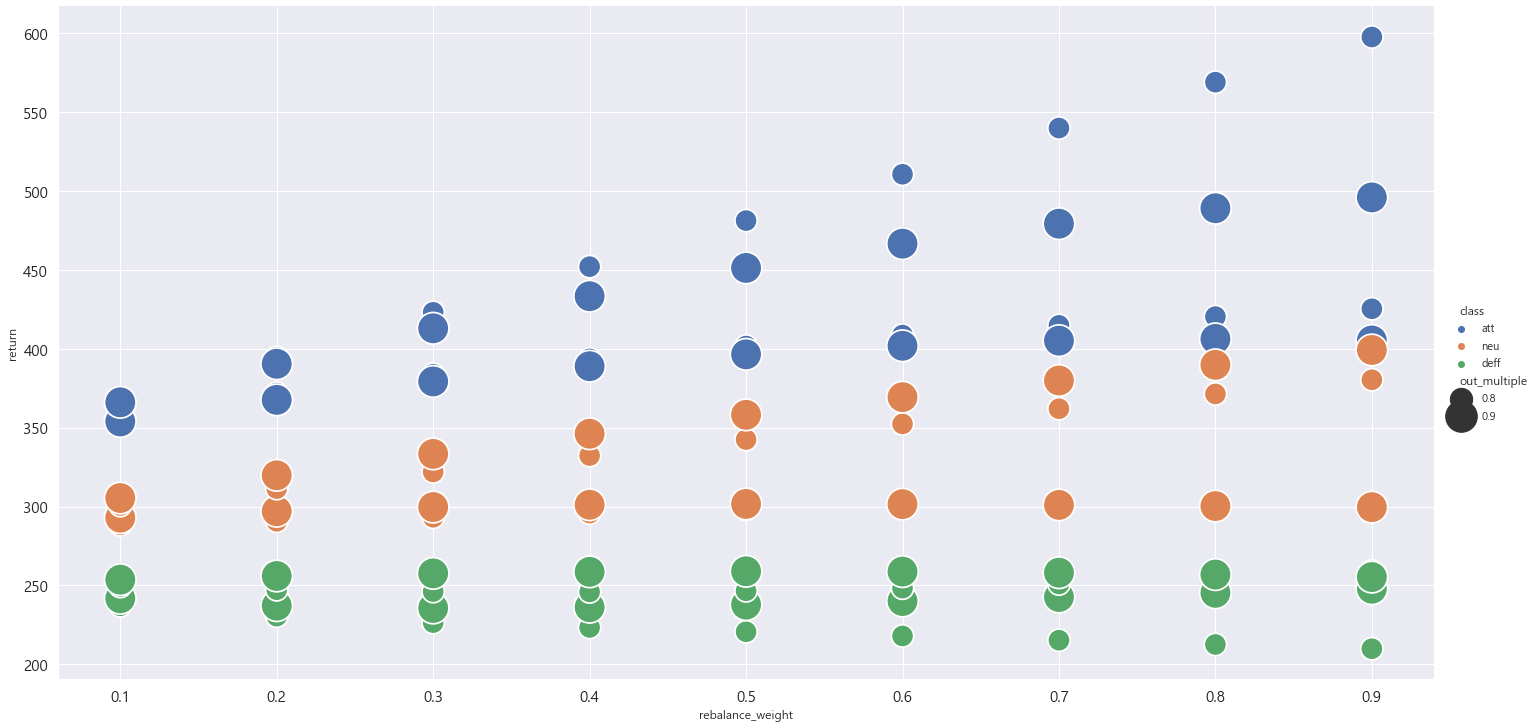

In [77]:
sns.relplot(
    data=rb_bt_stats[(rb_bt_stats['out_multiple'] > 0.7) & (rb_bt_stats['resid_diff'] > 10)], 
    x='rebalance_weight', y='return', kind='scatter', 
    hue='class', 
    size='out_multiple', sizes=(500, 1000), 
    height=10, aspect=2
)

In [78]:
rb_bt_stats[(rb_bt_stats['class'] == 'deff') & (rb_bt_stats['resid_diff'] == 20)].sort_values('return', ascending=False)

,class,return,rb_count,resid_diff,out_multiple,rebalance_weight
539,deff,259.173220,34,20,0.8,0.9
554,deff,259.001660,24,20,0.9,0.5
557,deff,258.795557,24,20,0.9,0.6
551,deff,258.645400,24,20,0.9,0.4
560,deff,258.089327,24,20,0.9,0.7
548,deff,257.658642,24,20,0.9,0.3
563,deff,256.911223,24,20,0.9,0.8
545,deff,256.011947,24,20,0.9,0.2
566,deff,255.319927,24,20,0.9,0.9
536,deff,254.550818,34,20,0.8,0.8


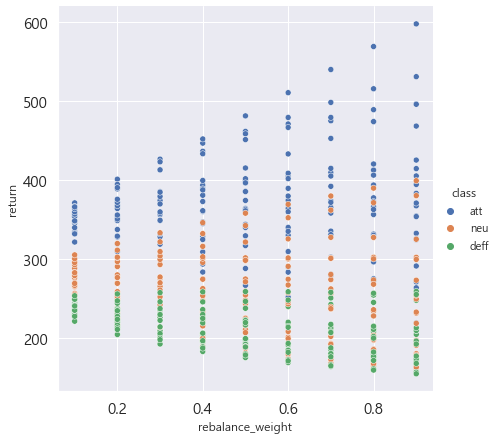

In [79]:
sns.relplot(
    data=rb_bt_stats, 
    x='rebalance_weight', y='return', kind='scatter', 
    hue='class', 
    # size='out_multiple', sizes=(20, 100), 
    height=6, 
)

# app.py

## 뷰안1

In [80]:
# 1번 박스 도넛차트
np.mean(glide_weight_att)

0.8407272727272729

In [81]:
# 1번 박스 선 차트
glide_weight_att

[1.0, 1.0, 1.0, 1.0, 0.953, 0.882, 0.831, 0.747, 0.678, 0.611, 0.546]

In [82]:
# 2번 박스 도넛차트
np.mean(glide_weight_neu)

0.6618181818181819

In [83]:
# 2번 박스 선 차트
glide_weight_neu

[0.76, 0.76, 0.735, 0.71, 0.685, 0.66, 0.638, 0.616, 0.594, 0.572, 0.55]

In [84]:
# 3번 박스 도넛차트
np.mean(glide_weight_def)

0.5329090909090909

In [85]:
# 3번 박스 선 차트
glide_weight_def

[0.71, 0.71, 0.67, 0.627, 0.583, 0.537, 0.485, 0.433, 0.393, 0.366, 0.348]

In [86]:
# 5번 박스 도넛차트
# 독일, 홍콩, 일본, 프랑스, 한국, S&P500, NASDAQ 순서
risk_weight

[0.025, 0.025, 0.0375, 0.0375, 0.25, 0.2, 0.425]

In [87]:
# 6번 박스 산점도 준비중

## 뷰안2

In [88]:
# 1번 박스 선 차트
bench_view2_1_att = bench_hv.loc[:, 'bench_att'].values.tolist() # [::20]
rb_view2_1_att    = bt_hv.loc[start_date_bt:, 'bt_att'].values.tolist()
bench_view2_1_neu = bench_hv.loc[:, 'bench_neu'].values.tolist() # [::20]
rb_view2_1_neu    = bt_hv.loc[start_date_bt:, 'bt_neu'].values.tolist()
bench_view2_1_def = bench_hv.loc[:, 'bench_def'].values.tolist() # [::20]
rb_view2_1_def    = bt_hv.loc[start_date_bt:, 'bt_def'].values.tolist()

In [89]:
bench_hv

,bench_att,bench_neu,bench_def,bench_att_HV,bench_att_HV_pred_5,bench_att_HV_pred_10,bench_att_HV_pred_15,bench_att_HV_pred_20,bench_att_HV_resid_5,bench_att_HV_resid_10,...,bench_neu_HV_resid_20,bench_def_HV,bench_def_HV_pred_5,bench_def_HV_pred_10,bench_def_HV_pred_15,bench_def_HV_pred_20,bench_def_HV_resid_5,bench_def_HV_resid_10,bench_def_HV_resid_15,bench_def_HV_resid_20
2011-09-29,100.000000,100.000000,100.000000,0.000000,0.360795,0.324120,0.305722,0.329484,-0.360795,-0.324120,...,-0.243648,0.000000,0.240325,0.219152,0.207621,0.225633,-0.240325,-0.219152,-0.207621,-0.225633
2011-09-30,96.894488,97.729429,97.903722,0.246492,0.335629,0.316655,0.303504,0.302691,-0.089136,-0.070162,...,-0.043594,0.166387,0.224012,0.214403,0.206887,0.207246,-0.057625,-0.048017,-0.040501,-0.040859
2011-10-03,94.167331,95.755132,96.086603,0.222310,0.372742,0.323141,0.303095,0.305007,-0.150432,-0.100831,...,-0.065349,0.148699,0.252209,0.218675,0.207005,0.210157,-0.103510,-0.069976,-0.058306,-0.061458
2011-10-04,96.395772,97.374284,97.578556,0.355046,0.352095,0.317429,0.307939,0.318360,0.002951,0.037617,...,0.019174,0.235599,0.238039,0.215160,0.209925,0.219600,-0.002440,0.020439,0.025674,0.015999
2011-10-05,98.063524,98.560755,98.664538,0.358458,0.338130,0.313585,0.300349,0.318001,0.020327,0.044873,...,0.020807,0.237138,0.228638,0.212739,0.204686,0.219951,0.008501,0.024399,0.032452,0.017188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,336.095047,283.306225,248.581924,0.061773,0.065345,0.062773,0.066844,0.074227,-0.003572,-0.001000,...,-0.011705,0.041410,0.045991,0.043357,0.045014,0.048638,-0.004581,-0.001947,-0.003604,-0.007228
2021-08-24,337.308545,284.252201,249.028843,0.061105,0.062106,0.063076,0.061904,0.077043,-0.001000,-0.001970,...,-0.015018,0.041283,0.043730,0.042812,0.041094,0.050837,-0.002447,-0.001529,0.000189,-0.009554
2021-08-25,337.400682,284.297035,248.904544,0.060321,0.063095,0.064273,0.062205,0.082508,-0.002774,-0.003952,...,-0.020631,0.040595,0.044427,0.043018,0.041977,0.052376,-0.003833,-0.002424,-0.001383,-0.011781
2021-08-26,335.678558,282.924285,248.093398,0.061997,0.062579,0.065880,0.066668,0.081637,-0.000582,-0.003883,...,-0.018245,0.041777,0.044334,0.044701,0.045354,0.052211,-0.002557,-0.002924,-0.003577,-0.010434


In [90]:
# 2번 박스 선 차트
bench_view2_2_att = bench_hv.loc[:, 'bench_att_HV'].values.tolist() # [::20]
rb_view2_2_att    = (bt_hv.loc[:, 'bt_att'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()
bench_view2_2_neu = bench_hv.loc[:, 'bench_neu_HV'].values.tolist() # [::20]
rb_view2_2_neu    = (bt_hv.loc[:, 'bt_neu'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()
bench_view2_2_def = bench_hv.loc[:, 'bench_def_HV'].values.tolist() # [::20]
rb_view2_2_def    = (bt_hv.loc[:, 'bt_def'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()

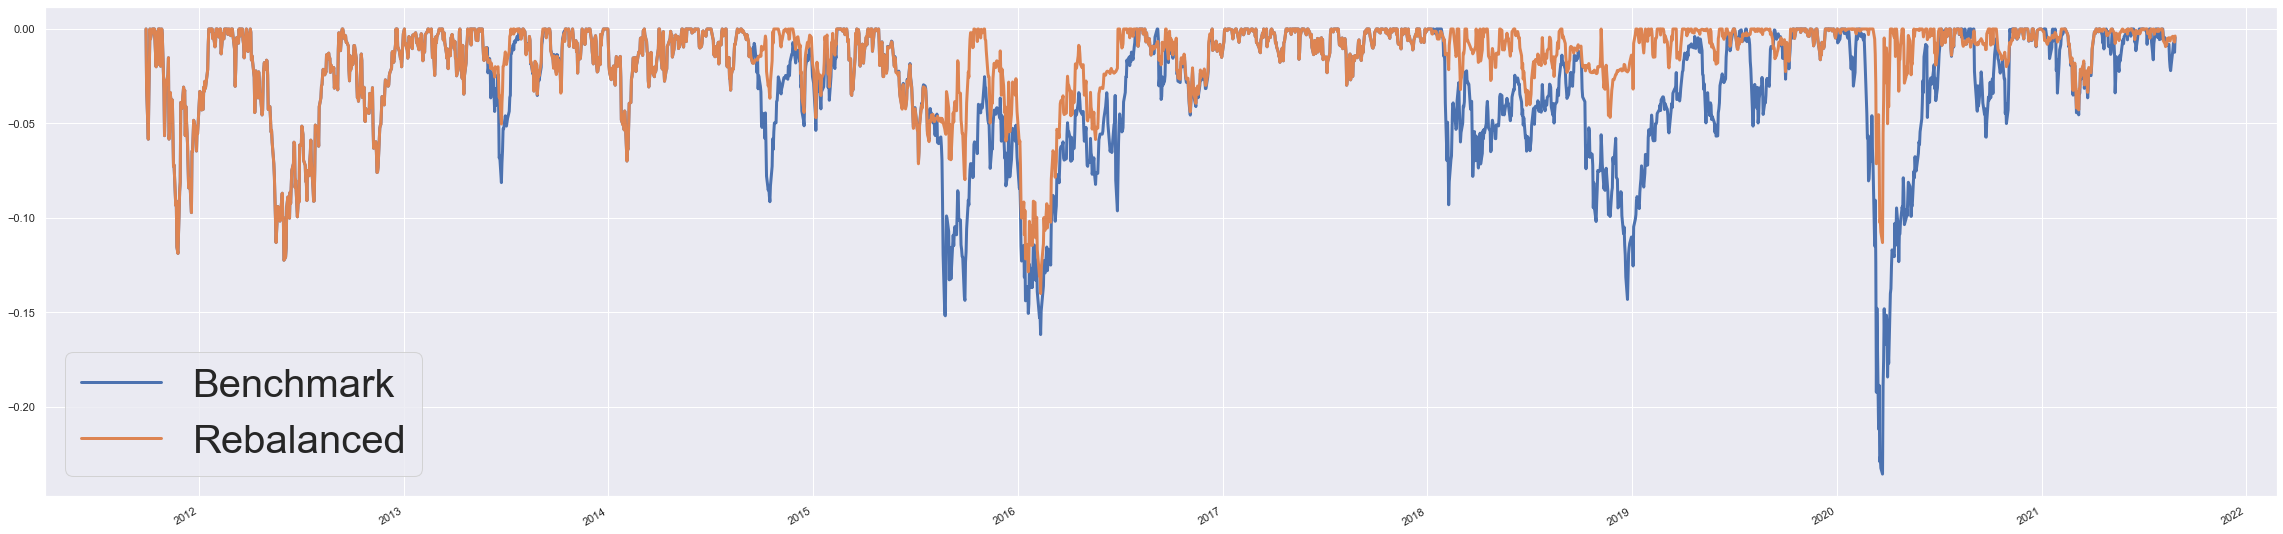

In [91]:
sns.set()

# 3번 박스 선 차트 : 공격형
pd.concat(
    [
        bench_hv['bench_att'].to_drawdown_series(), 
        bt_hv['bt_att'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(40, 10), lw=3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['Benchmark', 'Rebalanced'])

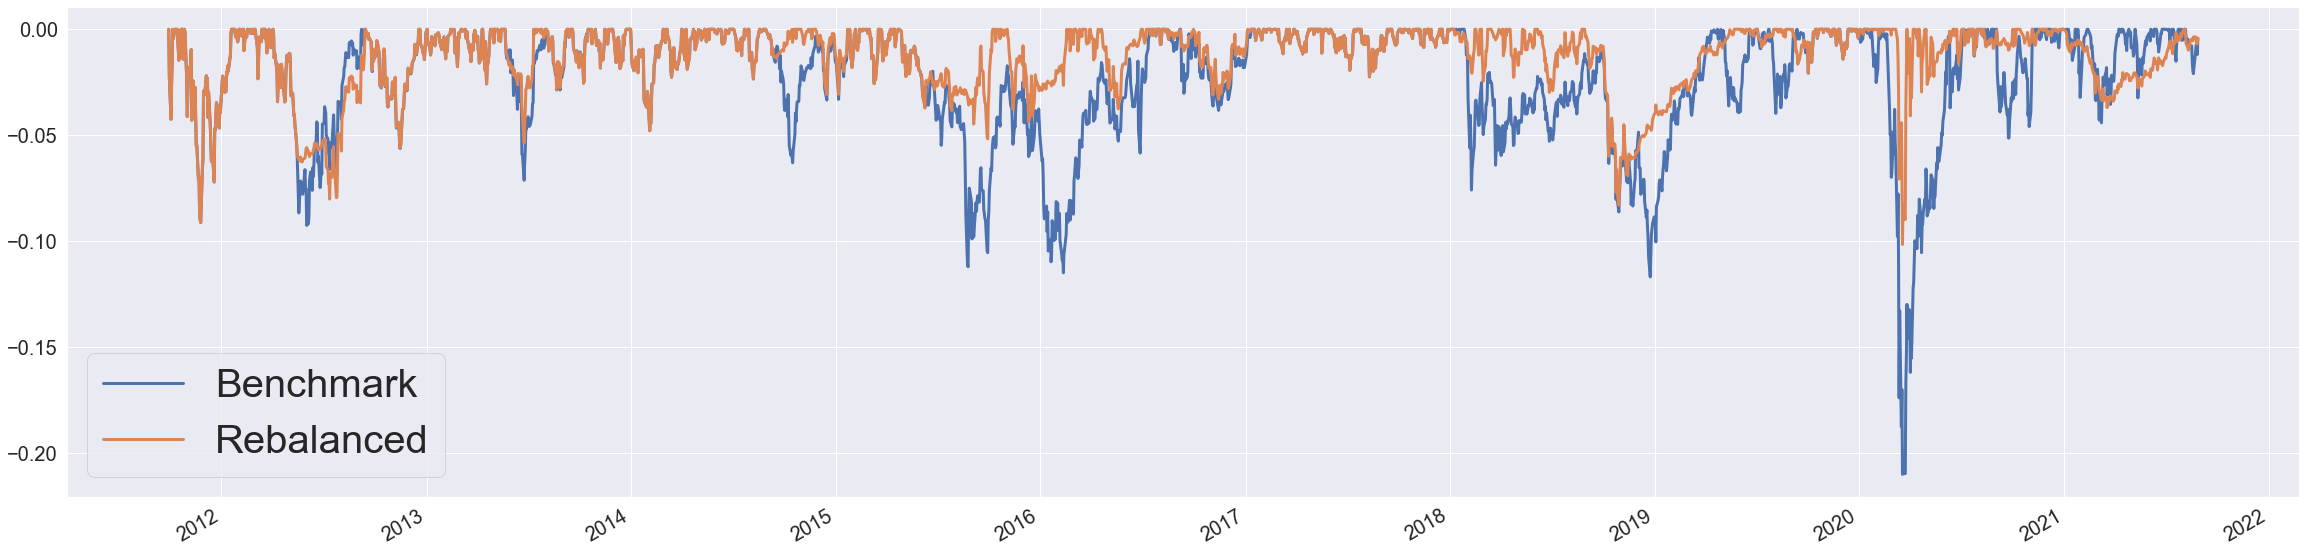

In [92]:
# 3번 박스 선 차트 : 중립형
pd.concat(
    [
        bench_hv['bench_neu'].to_drawdown_series(), 
        bt_hv['bt_neu'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(40, 10), lw=3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['Benchmark', 'Rebalanced'])

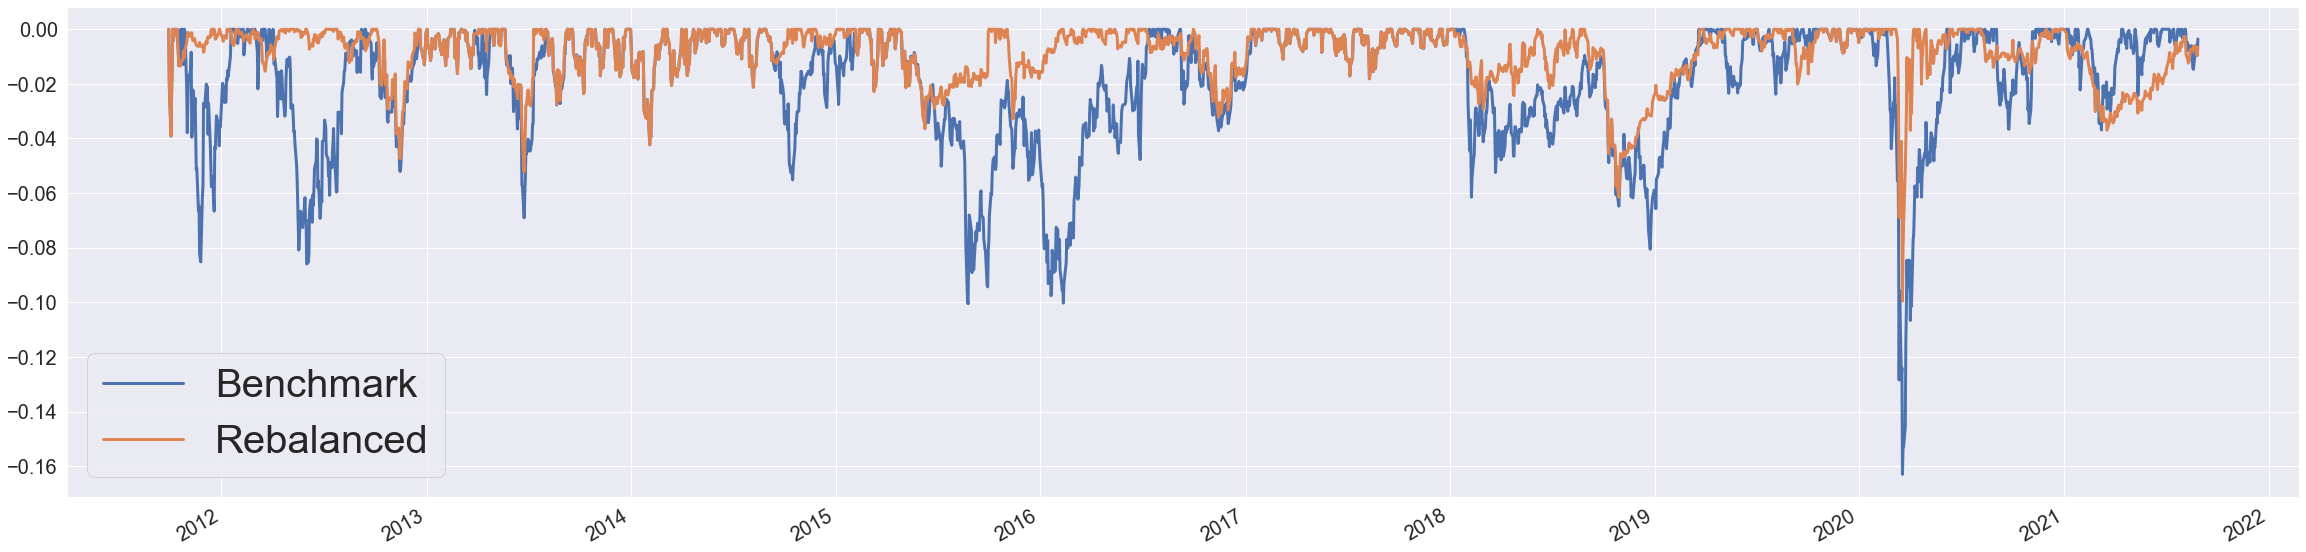

In [93]:
# 3번 박스 선 차트 : 방어형
pd.concat(
    [
        bench_hv['bench_def'].to_drawdown_series(), 
        bt_hv['bt_def'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(40, 10), lw=3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['Benchmark', 'Rebalanced'])

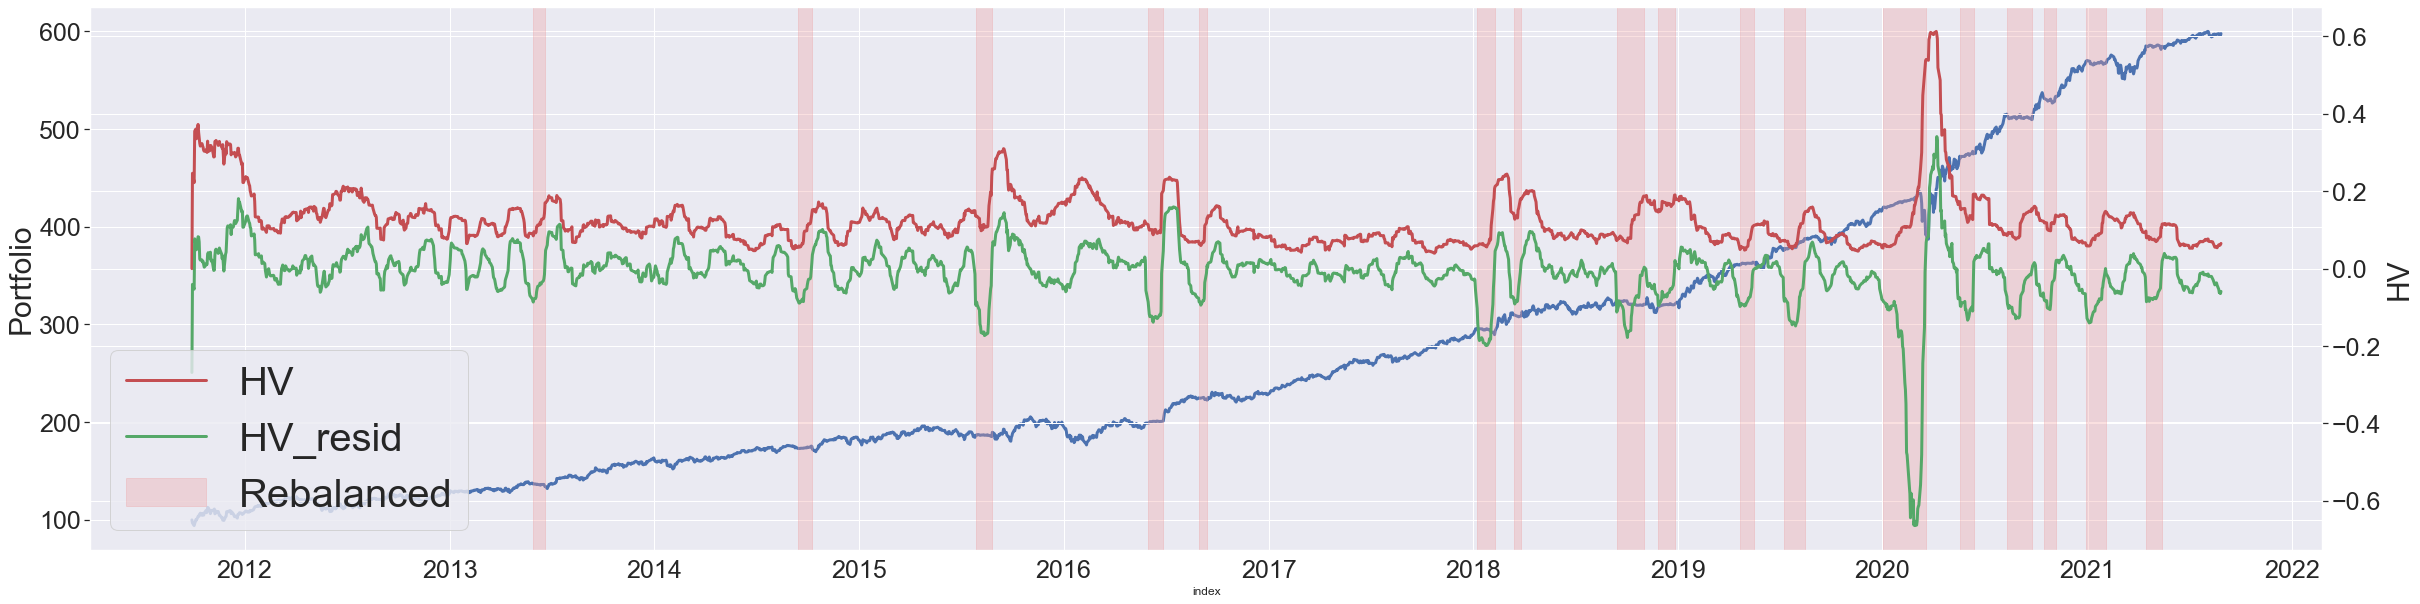

In [108]:
# 4번 박스 : 공격형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
sns.lineplot(ax=ax1, color='b', lw=3, y=bt_hv['bt_att'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_att['HV'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_att['HV_resid'], x=history_bt_att.index)

out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
for i, j in zip(out_idx_att, in_idx_att):
    ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=40, labels=['HV', 'HV_resid', 'Rebalanced'])

ax1.set_ylabel('Portfolio', fontsize=30)
ax2.set_ylabel('HV', fontsize=30)
plt.rc(['xtick', 'ytick'], labelsize=25)
plt.show()

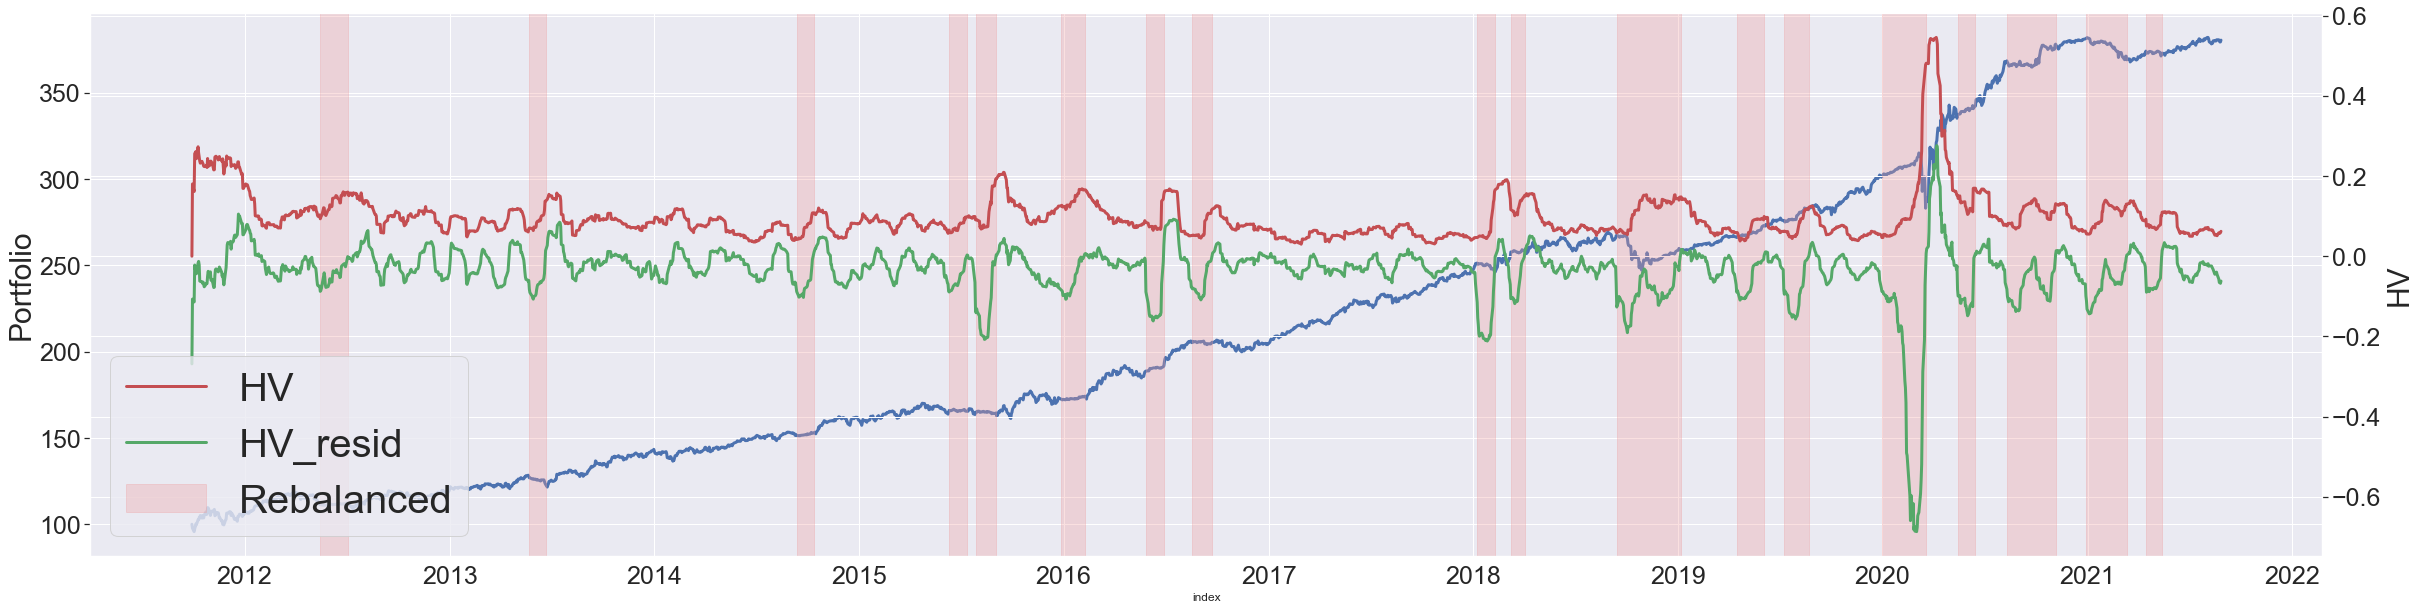

In [110]:
# 4번 박스 : 중립형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
sns.lineplot(ax=ax1, color='b', lw=3, y=bt_hv['bt_neu'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_neu['HV'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_neu['HV_resid'], x=history_bt_neu.index)

out_idx_neu = history_bt_neu[history_bt_neu['Fill_date'] == 'out'].index
in_idx_neu  = history_bt_neu[history_bt_neu['Fill_date'] == 'in'].index
for i, j in zip(out_idx_neu, in_idx_neu):
    ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['HV', 'HV_resid', 'Rebalanced'])

ax1.set_ylabel('Portfolio', fontsize=30)
ax2.set_ylabel('HV', fontsize=30)
plt.rc(['xtick', 'ytick'], labelsize=25)
plt.show()

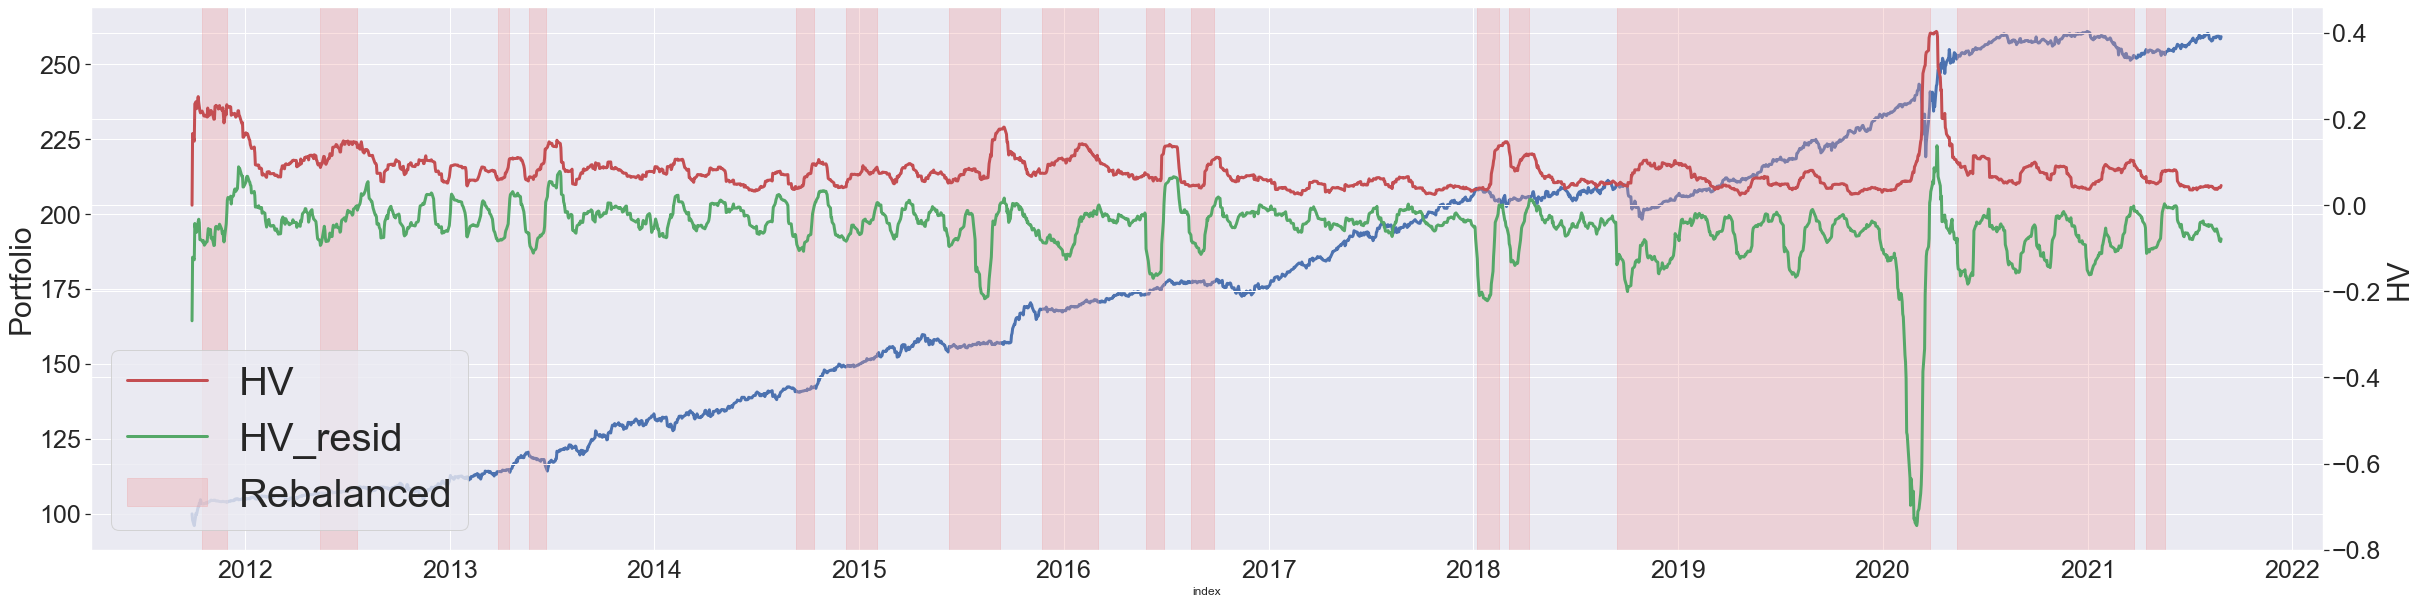

In [111]:
# 4번 박스 : 방어형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
sns.lineplot(ax=ax1, color='b', lw=3, y=bt_hv['bt_def'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_def['HV'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_def['HV_resid'], x=history_bt_def.index)

out_idx_def = history_bt_def[history_bt_def['Fill_date'] == 'out'].index
in_idx_def  = history_bt_def[history_bt_def['Fill_date'] == 'in'].index
for i, j in zip(out_idx_def, in_idx_def):
    ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['HV', 'HV_resid', 'Rebalanced'])

ax1.set_ylabel('Portfolio', fontsize=30)
ax2.set_ylabel('HV', fontsize=30)
plt.rc(['xtick', 'ytick'], labelsize=25)
plt.show()

In [97]:
# 5번, 6번 박스 방사형 수치
bench_view2_56_att = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bench_att'].values.tolist()
rb_view2_56_att    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bt_att'].values.tolist()
bench_view2_56_neu = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bench_neu'].values.tolist()
rb_view2_56_neu    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bt_neu'].values.tolist()
bench_view2_56_def = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bench_def'].values.tolist()
rb_view2_56_def    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bt_def'].values.tolist()

total_result = pd.DataFrame(
    {
        'bench_att': bench_view2_56_att, 
        'rb_att': rb_view2_56_att, 
        'bench_neu': bench_view2_56_neu, 
        'rb_neu': rb_view2_56_neu, 
        'bench_def': bench_view2_56_def, 
        'rb_def': rb_view2_56_def
    }, 
    index=['Total Return', 'CAGR', 'MDD', 'CALMR', 'Yearly Sharpe', 'Yearly Mean', 'Yearly Vol']
)
total_result

,bench_att,rb_att,bench_neu,rb_neu,bench_def,rb_def
Total Return,2.282139,4.976416,1.768579,2.803900,1.438983,1.591735
CAGR,0.126182,0.197621,0.107184,0.144268,0.093240,0.100826
MDD,-0.235534,-0.139997,-0.209966,-0.101554,-0.163010,-0.099599
CALMR,0.535729,1.411612,0.510481,1.420604,0.571991,1.012326
Yearly Sharpe,1.124273,1.809305,1.169588,1.700705,1.213739,1.376991
Yearly Mean,0.124053,0.192434,0.104789,0.139715,0.090152,0.096361
Yearly Vol,0.110341,0.106358,0.089595,0.082151,0.074276,0.069979


In [98]:
total_result.reset_index(inplace=True)

In [99]:
total_result.rename(columns={'index': 'ind'}, inplace=True)

In [100]:
total_result[['bench_att', 'rb_att', 'bench_neu', 'rb_neu', 'bench_def', 'rb_def']] = np.round(total_result[['bench_att', 'rb_att', 'bench_neu', 'rb_neu', 'bench_def', 'rb_def']], 4)
total_result

,ind,bench_att,rb_att,bench_neu,rb_neu,bench_def,rb_def
0,Total Return,2.2821,4.9764,1.7686,2.8039,1.4390,1.5917
1,CAGR,0.1262,0.1976,0.1072,0.1443,0.0932,0.1008
2,MDD,-0.2355,-0.1400,-0.2100,-0.1016,-0.1630,-0.0996
3,CALMR,0.5357,1.4116,0.5105,1.4206,0.5720,1.0123
4,Yearly Sharpe,1.1243,1.8093,1.1696,1.7007,1.2137,1.3770
5,Yearly Mean,0.1241,0.1924,0.1048,0.1397,0.0902,0.0964
6,Yearly Vol,0.1103,0.1064,0.0896,0.0822,0.0743,0.0700


In [101]:
# total_result.to_csv('./result.csv')

In [102]:
bt_hv

,bt_att,bt_neu,bt_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894488,97.729429,97.903722
2011-10-03,94.167331,95.755132,96.086603
2011-10-04,96.395772,97.374284,97.578556
...,...,...,...
2021-08-23,597.562784,380.584576,259.300739
2021-08-24,596.958437,380.028975,258.927963
2021-08-25,595.947580,379.308901,258.437073
2021-08-26,595.714417,379.340214,258.459158


In [103]:
bt_hv['bt_att_hv'] = bt_hv.loc[:, 'bt_att'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
bt_hv['bt_neu_hv'] = bt_hv.loc[:, 'bt_neu'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
bt_hv['bt_def_hv'] = bt_hv.loc[:, 'bt_def'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)

In [104]:
bt_hv = bt_hv[1:]

In [105]:
bench_hv[['bench_att', 'bench_neu', 'bench_def', 'bench_att_HV', 'bench_neu_HV', 'bench_def_HV']]

,bench_att,bench_neu,bench_def,bench_att_HV,bench_neu_HV,bench_def_HV
2011-09-29,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
2011-09-30,96.894488,97.729429,97.903722,0.246492,0.180221,0.166387
2011-10-03,94.167331,95.755132,96.086603,0.222310,0.161363,0.148699
2011-10-04,96.395772,97.374284,97.578556,0.355046,0.256043,0.235599
2011-10-05,98.063524,98.560755,98.664538,0.358458,0.257919,0.237138
...,...,...,...,...,...,...
2021-08-23,336.095047,283.306225,248.581924,0.061773,0.058561,0.041410
2021-08-24,337.308545,284.252201,249.028843,0.061105,0.057982,0.041283
2021-08-25,337.400682,284.297035,248.904544,0.060321,0.057204,0.040595
2021-08-26,335.678558,282.924285,248.093398,0.061997,0.058817,0.041777


In [106]:
bt_hv

,bt_att,bt_neu,bt_def,bt_att_hv,bt_neu_hv,bt_def_hv
2011-09-29,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000
2011-09-30,96.894488,97.729429,97.903722,0.246492,0.180221,0.166387
2011-10-03,94.167331,95.755132,96.086603,0.222310,0.161363,0.148699
2011-10-04,96.395772,97.374284,97.578556,0.355046,0.256043,0.235599
2011-10-05,98.063524,98.560755,98.664538,0.358458,0.257919,0.237138
...,...,...,...,...,...,...
2021-08-23,597.562784,380.584576,259.300739,0.026483,0.028205,0.028089
2021-08-24,596.958437,380.028975,258.927963,0.026048,0.027469,0.027368
2021-08-25,595.947580,379.308901,258.437073,0.026255,0.027868,0.027767
2021-08-26,595.714417,379.340214,258.459158,0.025997,0.027417,0.027326


In [107]:
# pd.concat(
#     [
#         bench_hv[['bench_att', 'bench_neu', 'bench_def', 'bench_att_HV', 'bench_neu_HV', 'bench_def_HV']],
#         bt_hv
#     ], axis=1
# ).to_csv('./returns_hv.csv')